# Set up dependencies

In [ ]:
%%capture
!git clone https://github.com/Tomiinek/MultiWOZ_Evaluation.git
!pip install spacy
!pip install lexical-diversity python-Levenshtein fuzzywuzzy
!pip install sacrebleu sacremoses
!python -m spacy download en_core_web_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# choose your own directory for data and output
root_dir = '/content/drive/MyDrive/CIS700 Project/'
#root_dir = '/content/drive/MyDrive/CIS700/neurosymbolic_dialog' 

Mounted at /content/drive/


# MultiWOZ 2.2 Constants & Database


In [ ]:
ALL_DOMAINS = ["attraction", "hotel", "restaurant", "taxi", "train", "hospital", "police"]

# SLOTS

REQUESTABLE_SLOTS = {
    "taxi": ["type", "phone"],
    "police": ["postcode", "address", "phone"],
    "hospital": ["address", "phone", "postcode"],
    "hotel": ["address", "postcode", "internet", "phone", "parking",
              "type", "pricerange", "stars", "area", "reference", "name"],
    "attraction": ["price", "type", "address", "postcode", "phone", "area", "reference", "name"],
    "train": ["duration", "leave", "price", "arrive", "id", "reference"],
    "restaurant": ["phone", "postcode", "address", "pricerange", "food", "area", "reference", "name"]
}

ALL_REQSLOT = ["type", "address", "postcode", "phone", "internet", "parking", "pricerange", "food",
               "stars", "area", "reference", "duration", "leave", "price", "arrive", "id"]

INFORMABLE_SLOTS = {
    "taxi": ["leave", "destination", "departure", "arrive"],
    "police": [],
    "hospital": ["department"],
    "hotel": ["type", "parking", "pricerange", "internet", "stay", "day", "people", "area", "stars", "name"],
    "attraction": ["area", "type", "name"],
    "train": ["destination", "day", "arrive", "departure", "people", "leave"],
    "restaurant": ["food", "pricerange", "area", "name", "time", "day", "people"]
}

ALL_INFSLOT = ["type", "parking", "pricerange", "internet", "stay", "day", "people", "area", "stars", "name",
               "leave", "destination", "departure", "arrive", "department", "food", "time"]

CATEGORICAL_SLOTS = {
    "hotel": {
        "pricerange": ["expensive", "moderate", "cheap"],
        "area": ["centre", "east", "north", "south", "west"],
        "type": ["guesthouse", "hotel"],
        "parking": ["yes", "no"],
        "internet": ["yes", "no"],
        "stay": ["1", "2", "3", "4", "5", "6", "7", "8"],
        "people": ["1", "2", "3", "4", "5", "6", "7", "8"],
        "day": ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"],
        "stars": ["0", "1", "2", "3", "4", "5"]
    },
    "restaurant": {
        "pricerange": ["expensive", "moderate", "cheap"],
        "area": ["centre", "east", "north", "south", "west"],
        "people": ["1", "2", "3", "4", "5", "6", "7", "8"],
        "day": ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"],
    },
    "attraction": {
        "area": ["centre", "east", "north", "south", "west"],
        "type": ["architecture", "boat", "cinema", "college", "concerthall", "entertainment",
                 "museum", "multiple sports", "nightclub", "park", "swimmingpool", "theatre"],
    },
    "train": {
        "departure": ["birmingham new street", "bishops stortford", "broxbourne", "cambridge",
                      "ely", "kings lynn", "leicester", "london kings cross", "london liverpool street",
                      "norwich", "peterborough", "stansted airport", "stevenage"],
        "destination": ["birmingham new street", "bishops stortford", "broxbourne", "cambridge",
                        "ely", "kings lynn", "leicester", "london kings cross", "london liverpool street",
                        "norwich", "peterborough", "stansted airport", "stevenage"],
        "day": ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"],
        "people": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "15"]
    },
    "taxi": {},
    "hospital": {},
    "police": {
        "name": ["parkside police station"]
    }
}

# Ordered by priority
ENTITY_SLOTS = {
    "hotel": ["area", "pricerange", "type", "stars", "parking",
              "internet", "name", "phone", "address", "postcode"],
    "restaurant": ["food", "area", "pricerange", "name", "address", "phone", "postcode"],
    "attraction": [],
    "train": [],
    "taxi": [],
    "police": [],
    "hospital": []
}

USER_SLOTS = {
    "hotel": ["stay", "day", "people", "reference"],
    "restaurant": ["time", "day", "people", "reference"],
    "attraction": [],
    "train": [],
    "taxi": [],
    "police": [],
    "hospital": []
}


# Dialog Actions

USER_ACTIONS = ['inform', 'request', 'thank', 'bye', 'greet']

SYSTEM_ACTIONS = {
    'restaurant': ['inform', 'request', 'nooffer', 'recommend', 'select', 'offerbook', 'offerbooked', 'nobook'],
    'hotel': ['inform', 'request', 'nooffer', 'recommend', 'select', 'offerbook', 'offerbooked', 'nobook'],
    'attraction': ['inform', 'request', 'nooffer', 'recommend', 'select'],
    'train': ['inform', 'request', 'nooffer', 'offerbook', 'offerbooked', 'select'],
    'taxi': ['inform', 'request'],
    'police': ['inform', 'request'],
    'hospital': ['inform', 'request'],
    'general': ['bye', 'greet', 'reqmore', 'thank', 'welcome']
}

Fuzzy matching is supported so that we can match different variations of slot values extracted from utterances

In [ ]:
%cd /content/MultiWOZ_Evaluation
from pathlib import Path
import random
import json

from fuzzywuzzy import fuzz
from mwzeval.normalization import normalize_state_slot_value, time_str_to_minutes


class MultiWozDB:
    """ MultiWoZ JSON Handler class """

    DB_DOMAINS = ["attraction", "hotel", "restaurant", "train"]

    FUZZY_KEYS = {
        'hotel' : {'name'},
        'attraction' : {'name'},
        'restaurant' : {'name', 'food'},
        'train' : {'departure', 'destination'}
    }

    def __init__(self, db_dir):
        self.dbs = {}
        self.db_keys = {}

        for domain in ALL_DOMAINS:
            with open(Path(db_dir) / f"{domain}_db_processed.json", "r", encoding="utf-8") as f:
                self.dbs[domain] = json.loads(f.read().lower())
            self.db_keys[domain] = set(self.dbs[domain][0].keys())

    def one_hot_vector(self, domain, num):
        """Return number of available entities for particular domain."""
        vector = [0, 0, 0, 0]
        if num == '':
            return vector
        if domain != 'train':
            if num == 0:
                vector = [1, 0, 0, 0]
            elif num == 1:
                vector = [0, 1, 0, 0]
            elif num <= 3:
                vector = [0, 0, 1, 0]
            else:
                vector = [0, 0, 0, 1]
        else:
            if num == 0:
                vector = [1, 0, 0, 0]
            elif num <= 5:
                vector = [0, 1, 0, 0]
            elif num <= 10:
                vector = [0, 0, 1, 0]
            else:
                vector = [0, 0, 0, 1]
        return vector

    def addBookingPointer(self, turn_da):
        """Add information about availability of the booking option."""
        # Booking pointer
        # Do not consider booking two things in a single turn.
        vector = [0, 0]
        if turn_da.get('booking-nobook'):
            vector = [1, 0]
        if turn_da.get('booking-book') or turn_da.get('train-offerbooked'):
            vector = [0, 1]
        return vector

    def addDBPointer(self, domain, match_num, return_num=False):
        """Create database pointer for all related domains."""
        if domain in self.DB_DOMAINS:
            vector = self.one_hot_vector(domain, match_num)
        else:
            vector = [0, 0, 0, 0]
        return vector

    def addDBIndicator(self, domain, match_num, return_num=False):
        """Create database indicator for all related domains."""
        if domain in self.DB_DOMAINS:
            vector = self.one_hot_vector(domain, match_num)
        else:
            vector = [0, 0, 0, 0]

        # '[db_nores]', '[db_0]', '[db_1]', '[db_2]', '[db_3]'
        if vector == [0, 0, 0, 0]:
            indicator = '[db_null]'
        else:
            indicator = '[db_%s]' % vector.index(1)
        return indicator

    def get_match_num(self, constraints, return_entry=False):
        """Create database pointer for all related domains."""
        match = {'general': ''}
        entry = {}
        for domain in ALL_DOMAINS:
            match[domain] = ''
            if domain in self.DB_DOMAINS and constraints.get(domain):
                matched_ents = self.query(domain, constraints[domain])
                match[domain] = len(matched_ents)
                if return_entry:
                    entry[domain] = matched_ents
        if return_entry:
            return entry
        return match

    def pointerBack(self, vector, domain):
        # multi domain implementation
        if domain.endswith(']'):
            domain = domain[1:-1]
        if domain != 'train':
            nummap = {
                0: '0',
                1: '1',
                2: '2-3',
                3: '>3'
            }
        else:
            nummap = {
                0: '0',
                1: '1-5',
                2: '6-10',
                3: '>10'
            }
        if vector[:4] == [0, 0, 0, 0]:
            report = ''
        else:
            num = vector.index(1)
            report = domain+': '+nummap[num] + '; '

        if vector[-2] == 0 and vector[-1] == 1:
            report += 'booking: ok'
        if vector[-2] == 1 and vector[-1] == 0:
            report += 'booking: unable'

        return report

    def query(self, domain, constraints, fuzzy_ratio=85):

        # Hotel database keys:      address, area, name, phone, postcode, pricerange, type, internet, parking, stars (other are ignored)
        # Attraction database keys: address, area, name, phone, postcode, pricerange, type, entrance fee (other are ignored)
        # Restaurant database keys: address, area, name, phone, postcode, pricerange, type, food 
        # Train database contains keys: arriveby, departure, day, leaveat, destination, trainid, price, duration
        
        # query the db
        if domain == 'taxi':
            return [{'taxi_colors': random.choice(self.dbs[domain]['taxi_colors']),
                     'taxi_types': random.choice(self.dbs[domain]['taxi_types']),
                     'taxi_phone': [random.randint(1, 9) for _ in range(10)]}]
        if domain == 'police':
            return self.dbs['police']
        if domain == 'hospital':
            if constraints.get('department'):
                for entry in self.dbs['hospital']:
                    if entry.get('department') == constraints.get('department'):
                        return [entry]
            else:
                return []
        
        results = []
        query = {}
        for key in self.db_keys[domain]:  
            if key in constraints:
                if constraints[key] in ["dontcare", "not mentioned", "don't care", "dont care", "do n't care", "do not care", "none", "unknown", ""]:
                    continue
                query[key] = normalize_state_slot_value(key, constraints[key])
                if key in ['arrive', 'leave']:
                    query[key] = time_str_to_minutes(query[key])
            else:
                query[key] = None
                        
        for item in self.dbs[domain]:
            for k, v in query.items():
                if v is None or item[k] == '?':
                    continue

                if k == 'arrive':
                    time = time_str_to_minutes(item[k]) 
                    if time > v:
                        break
                elif k == 'leave':
                    time = time_str_to_minutes(item[k]) 
                    if time < v:
                        break
                else:
                    if k in self.FUZZY_KEYS.get(domain, {}):
                        f = (lambda x: fuzz.partial_ratio(item[k], x) < fuzzy_ratio)
                    else:
                        f = (lambda x: item[k] != x)
                    if f(v):
                        break
            else:
                results.append(item)

        return results

/content/MultiWOZ_Evaluation


# Preprocess & Delexicalize MultiWOZ 2.2
Delexicalization replaces specific values in system reponses with placeholders like `[value_food]`, `[value_area]`, etc.

WARNING: this will take an hour! You can copy/mount MultiWOZ_2.1 and processed_multiwoz in shared drive to your root directory set above and skip this section.

In [ ]:
%%capture
%cd /content
!git clone https://github.com/budzianowski/multiwoz.git
!git clone https://github.com/bepoetree/MTTOD.git
!apt install git-lfs

In [ ]:
%cd /content/MTTOD
!git lfs install
!git lfs pull
!git checkout -f HEAD
!unzip -q -o data.zip -d data

# Apply 2.2 corrections to 2.1 so that we can use 2.1's format
!python /content/multiwoz/data/MultiWOZ_2.2/convert_to_multiwoz_format.py --multiwoz21_data_dir=data/MultiWOZ_2.1 --output_file=data/MultiWOZ_2.1/data.json
!cp /content/multiwoz/data/MultiWOZ_2.2/schema.json data/MultiWOZ_2.1

/content/MTTOD
Updated git hooks.
Git LFS initialized.
Your branch is up to date with 'origin/main'.
I0427 07:41:29.686999 140589032601472 convert_to_multiwoz_format.py:86] Dialogue SNG01862.json doesn't exist in MultiWOZ 2.2.
I0427 07:41:52.481241 140589032601472 convert_to_multiwoz_format.py:109] Finish writing 10437 dialogues


Next, we start preprocessing

In [ ]:
%cd /content/MTTOD
import os
import re
import copy
import argparse
from collections import OrderedDict

import spacy
from tqdm import tqdm

from utils import definitions
from utils.io_utils import load_json, save_json, load_text
from utils.clean_dataset import clean_time


def clean_text(text, mapping_pair=None):
    text = text.strip()
    text = text.lower()

    text = text.replace("`", "")
    text = text.replace(u"’", "'")
    text = text.replace(u"‘", "'")
    text = text.replace(';', ',')
    text = text.replace('"', ' ')
    text = text.replace('/', ' and ')
    text = text.replace("don't", "do n't")
    text = clean_time(text)
    baddata = {r'c\.b (\d), (\d) ([a-z])\.([a-z])': r'cb\1\2\3\4',
               'c.b. 1 7 d.y': 'cb17dy',
               'c.b.1 7 d.y': 'cb17dy',
               'c.b 25, 9 a.q': 'cb259aq',
               'isc.b 25, 9 a.q': 'is cb259aq',
               'c.b2, 1 u.f': 'cb21uf',
               'c.b 1,2 q.a': 'cb12qa',
               '0-122-336-5664': '01223365664',
               'postcodecb21rs': 'postcode cb21rs',
               r'i\.d': 'id',
                        ' i d ': ' id ',
                        'Telephone:01223358966': 'Telephone: 01223358966',
                        'depature': 'departure',
                        'depearting': 'departing',
                        '-type': ' type',
                        r"b[\s]?&[\s]?b": "bed and breakfast",
                        "b and b": "bed and breakfast",
                        "wo n\'t": "will not",
                        " \'d ": " would ",
                        " \'m ": " am ",
                        " \'re' ": " are ",
                        " \'ll' ": " will ",
                        " \'ve ": " have ",
                        r'^\'': '',
                        r'\'$': '',
               }
    for tmpl, good in baddata.items():
        text = re.sub(tmpl, good, text)

    text = re.sub(r'([a-zT]+)\.([a-z])', r'\1 . \2', text)   # 'abc.xyz' -> 'abc . xyz'
    text = re.sub(r'(\w+)\.\.? ', r'\1 . ', text)   # if 'abc. ' -> 'abc . '

    if mapping_pair is not None:
        for (fromx, tox) in mapping_pair:
            text = ' ' + text + ' '
            text = text.replace(' ' + fromx + ' ', ' ' + tox + ' ')[1:-1]

    return text


def clean_slot_values(domain, slot, value, mapping_pair=None):
    value = clean_text(value, mapping_pair)
    if not value:
        value = ''
    elif value == 'not mentioned':
        value = ''
        # value = 'not mentioned' # if in DST setting
    elif domain == 'attraction':
        if slot == 'name':
            if value == 't':
                value = ''
            if value == 'trinity':
                value = 'trinity college'
        elif slot == 'area':
            if value in ['town centre', 'cent', 'center', 'ce']:
                value = 'centre'
            elif value in ['ely', 'in town', 'museum', 'norwich', 'same area as hotel']:
                value = ""
            elif value in ['we']:
                value = "west"
        elif slot == 'type':
            if value in ['m', 'mus', 'musuem']:
                value = 'museum'
            elif value in ['art', 'architectural']:
                value = "architecture"
            elif value in ['churches']:
                value = "church"
            elif value in ['coll']:
                value = "college"
            elif value in ['concert', 'concert hall']:
                value = 'concerthall'
            elif value in ['night club']:
                value = 'nightclub'
            elif value in ['mutiple sports', 'mutliple sports', 'sports', 'galleria']:
                value = 'multiple sports'
            elif value in ['ol', 'science', 'gastropub', 'la raza']:
                value = ''
            elif value in ['swimming pools', 'swimming pool', 'pool']:
                value = 'swimmingpool'
            elif value in ['fun']:
                value = 'entertainment'
        elif slot in ['entrancefee', 'entrance fee', 'fee']:
            slot = 'price'
        elif slot in ['open hours']:
            slot = 'openhours'

    elif domain == 'hotel':
        if slot == 'area':
            if value in ['cen', 'centre of town', 'near city center', 'center']:
                value = 'centre'
            elif value in ['east area', 'east side']:
                value = 'east'
            elif value in ['in the north', 'north part of town']:
                value = 'north'
            elif value in ['we']:
                value = "west"
        elif slot == "day":
            if value == "monda":
                value = "monday"
            elif value == "t":
                value = "tuesday"
        elif slot == 'name':
            if value == 'uni':
                value = 'university arms hotel'
            elif value == 'university arms':
                value = 'university arms hotel'
            elif value == 'acron':
                value = 'acorn guesthouse'
            elif value == 'ashley':
                value = 'ashley hotel'
            elif value == 'la':
                value = 'la margherit'
            elif value == 'no':
                value = ''
        elif slot == 'internet':
            if value == 'does not':
                value = 'no'
            elif value in ['y', 'free', 'free internet']:
                value = 'yes'
            elif value in ['4']:
                value = ''
        elif slot == 'parking':
            if value == 'n':
                value = 'no'
            elif value in ['free parking', 'free']:
                value = 'yes'
            elif value in ['y']:
                value = 'yes'
        elif slot in ['pricerange', 'price range']:
            slot = 'pricerange'
            if 'moderate' in value:
                value = 'moderate'
            elif 'expensive' in value:
                value = 'expensive'
            elif value in ['any']:
                value = "dontcare"
            elif value == 'inexpensive' or 'cheap' in value:
                value = "cheap"
            elif value in ['2', '4']:
                value = ''
        elif slot == 'stars':
            if value == 'two':
                value = '2'
            elif value == 'three':
                value = '3'
            elif value in ['4-star', '4 stars', '4 star', 'four star', 'four stars']:
                value = '4'
        elif slot == 'type':
            if value == '0 star rarting':
                value = ''
            # elif value in ['guest house', 'questhouse', 'quest house']:
            #     value = 'guesthouse'
            elif value in ['guest house', 'questhouse', 'quest house', 'guest houses']:
                value = 'guesthouse'
            elif value == 'hotels':
                value = 'hotel'
            elif value not in ['hotel', 'guesthouse', "dontcare", '?']:
                value = ''
    elif domain == 'restaurant':
        if slot == "area":
            if value in ["center", 'scentre', "center of town", "city center",
                         "cb30aq", "town center", 'centre of cambridge', 'city centre']:
                value = "centre"
            elif value == "west part of town":
                value = "west"
            elif value == "n":
                value = "north"
            elif value in ['the south']:
                value = 'south'
            elif value not in ['centre', 'south', "dontcare", 'west', 'east', 'north', '?']:
                value = ''
        elif slot == "day":
            if value == "monda":
                value = "monday"
            elif value == "t":
                value = "tuesday"
        elif slot in ['pricerange', 'price range']:
            slot = 'pricerange'
            if value in ['mode', 'mo'] or 'moderate' in value:
                value = 'moderate'
            elif value in ['not']:
                value = ''
            elif value in ['inexpensive', 'ch'] or 'cheap' in value:
                value = "cheap"
            elif 'expensive' in value:
                value = 'expensive'
        elif slot == "food":
            if value == "barbecue":
                value = "barbeque"
        elif slot == "time":
            if value == "9:00":
                value = "09:00"
            elif value == "9:45":
                value = "09:45"
            elif value == "1330":
                value = "13:30"
            elif value == "1430":
                value = "14:30"
            elif value == "9:15":
                value = "09:15"
            elif value == "9:30":
                value = "09:30"
            elif value == "1830":
                value = "18:30"
            elif value == "9":
                value = "09:00"
            elif value == "2:00":
                value = "14:00"
            elif value == "1:00":
                value = "13:00"
            elif value == "3:00":
                value = "15:00"
    elif domain == 'taxi':
        if slot in ['arriveBy', 'arrive by']:
            slot = 'arriveby'
            if value == '1530':
                value = '15:30'
            elif value == '15 minutes':
                value = ''
        elif slot in ['leaveAt', 'leave at']:
            slot = 'leaveat'
            if value == '1:00':
                value = '01:00'
            elif value == '21:4':
                value = '21:04'
            elif value == '4:15':
                value = '04:15'
            elif value == '5:45':
                value = '05:45'
            elif value == '0700':
                value = '07:00'
            elif value == '4:45':
                value = '04:45'
            elif value == '8:30':
                value = '08:30'
            elif value == '9:30':
                value = '09:30'
            value = value.replace(".", ":")
        elif slot in ['car', 'car type']:
            slot = 'type'

    elif domain == 'train':
        if slot in ['arriveBy', 'arrive by']:
            slot = 'arriveby'
            if value == '1':
                value = '01:00'
            elif value in ['does not care', 'doesnt care', "doesn't care"]:
                value = "dontcare"
            elif value == '8:30':
                value = '08:30'
            elif value == 'not 15:45':
                value = ''
            value = value.replace(".", ":")
        elif slot == 'day':
            if value == 'doesnt care' or value == "doesn't care":
                value = "dontcare"
        elif slot in ['leaveAt', 'leave at']:
            slot = 'leaveat'
            if value == '2:30':
                value = '02:30'
            elif value == '7:54':
                value = '07:54'
            elif value == 'after 5:45 pm':
                value = '17:45'
            elif value in ['early evening', 'friday', 'sunday', 'tuesday', 'afternoon']:
                value = ''
            elif value == '12':
                value = '12:00'
            elif value == '1030':
                value = '10:30'
            elif value == '1700':
                value = '17:00'
            elif value in ['does not care', 'doesnt care', 'do nt care', "doesn't care"]:
                value = "dontcare"
            value = value.replace(".", ":")
        elif slot in ['trainid', 'train id']:
            slot = 'id'
        elif slot == 'time':
            slot = 'duration'
    if value in ['dont care', "don't care", "do nt care", "doesn't care"]:
        value = "dontcare"
    if definitions.NORMALIZE_SLOT_NAMES.get(slot):
        slot = definitions.NORMALIZE_SLOT_NAMES[slot]
    if slot.startswith('book'):
        slot = slot[4:]
    return slot, value


class Preprocessor(object):
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

        suffixes = list(self.nlp.Defaults.suffixes)
        suffixes.remove("\]")
        suffix_regex = spacy.util.compile_suffix_regex(suffixes)
        self.nlp.tokenizer.suffix_search = suffix_regex.search

        prefixes = list(self.nlp.Defaults.prefixes)
        prefixes.remove("\[")
        prefix_regex = spacy.util.compile_prefix_regex(prefixes)
        self.nlp.tokenizer.prefix_search = prefix_regex.search

        self.data_dir = os.path.join('data', 'MultiWOZ_2.1')

        self.save_dir = os.path.join(root_dir, 'processed_multiwoz')
        os.makedirs(self.save_dir, exist_ok=True)

        data_name = "data.json"
        self.dev_list = load_text(os.path.join(self.data_dir, "valListFile.txt"))
        self.test_list = load_text(os.path.join(self.data_dir, "testListFile.txt"))
        self.do_tokenize_text = True

        self.mapping_pair = self.load_mapping_pair()

        # self.preprocess_db()

        self.db = MultiWozDB(os.path.join(self.data_dir, "db"))
        self.data = load_json(os.path.join(self.data_dir, data_name))

        self.delex_sg_valdict_path = os.path.join(self.save_dir, "delex_single_valdict.json")
        self.delex_mt_valdict_path = os.path.join(self.save_dir, "delex_multi_valdict.json")
        self.ambiguous_val_path = os.path.join(self.save_dir, "ambiguous_values.json")

        if (not os.path.exists(self.delex_sg_valdict_path) or
                not os.path.exists(self.delex_mt_valdict_path) or
                not os.path.exists(self.ambiguous_val_path)):
            self.delex_sg_valdict, self.delex_mt_valdict, self.ambiguous_vals = self.get_delex_valdict()
        else:
            self.delex_sg_valdict = load_json(self.delex_sg_valdict_path)
            self.delex_mt_valdict = load_json(self.delex_mt_valdict_path)
            self.ambiguous_vals = load_json(self.ambiguous_val_path)

    def load_mapping_pair(self):
        mapping_pair = []

        with open('utils/mapping.pair', 'r') as fin:
            for line in fin.readlines():
                fromx, tox = line.replace('\n', '').split('\t')
                mapping_pair.append((fromx, tox))
        return mapping_pair

    def preprocess_db(self):
        dbs = {}
        for domain in definitions.ALL_DOMAINS:
            db_path = os.path.join(self.data_dir, "db", "{}_db.json".format(domain))

            dbs[domain] = load_json(db_path)

            for idx, entry in enumerate(dbs[domain]):
                new_entry = copy.deepcopy(entry)
                for key, value in entry.items():
                    if type(value) is not str:
                        continue
                    del new_entry[key]
                    key, value = clean_slot_values(domain, key, value)
                    tokenize_and_back = ' '.join(
                        [token.text for token in self.nlp(value)]).strip()
                    new_entry[key] = tokenize_and_back
                dbs[domain][idx] = new_entry

            save_json(dbs[domain], os.path.join(self.data_dir, "db", "{}_db_processed.json".format(domain)))

            print("[{}] DB processed !".format(domain))

    def get_delex_valdict(self):
        skip_entry_type = {
            'taxi': ['taxi_phone'],
            'police': ['id'],
            'hospital': ['id'],
            'hotel': ['id', 'location', 'internet', 'parking', 'takesbookings',
                      'stars', 'price', 'n', 'postcode', 'phone'],
            'attraction': ['id', 'location', 'pricerange', 'price', 'openhours', 'postcode', 'phone'],
            'train': ['price', 'id'],
            'restaurant': ['id', 'location', 'introduction', 'signature', 'type', 'postcode', 'phone'],
        }
        entity_value_to_slot = {}
        ambiguous_entities = []
        for domain, db_data in self.db.dbs.items():
            print('Processing entity values in [%s]' % domain)
            if domain != 'taxi':
                for db_entry in db_data:
                    for slot, value in db_entry.items():
                        if slot not in skip_entry_type[domain]:
                            if type(value) is not str:
                                raise TypeError(
                                    "value '%s' in domain '%s' should be rechecked" % (slot, domain))
                            else:
                                slot, value = clean_slot_values(domain, slot, value)
                                value = ' '.join(
                                    [token.text for token in self.nlp(value)]).strip()
                                if value in entity_value_to_slot and entity_value_to_slot[value] != slot:
                                    # print(value, ": ",entity_value_to_slot[value], slot)
                                    ambiguous_entities.append(value)
                                entity_value_to_slot[value] = slot
            else:   # taxi db specific
                db_entry = db_data[0]
                for slot, ent_list in db_entry.items():
                    if slot not in skip_entry_type[domain]:
                        for ent in ent_list:
                            entity_value_to_slot[ent] = 'car'
        ambiguous_entities = set(ambiguous_entities)
        ambiguous_entities.remove('cambridge')
        ambiguous_entities = list(ambiguous_entities)
        for amb_ent in ambiguous_entities:   # departure or destination? arrive time or leave time?
            entity_value_to_slot.pop(amb_ent)
        entity_value_to_slot['parkside'] = 'address'
        entity_value_to_slot['parkside, cambridge'] = 'address'
        entity_value_to_slot['cambridge belfry'] = 'name'
        entity_value_to_slot['hills road'] = 'address'
        entity_value_to_slot['hills rd'] = 'address'
        entity_value_to_slot['Parkside Police Station'] = 'name'

        single_token_values = {}
        multi_token_values = {}
        for val, slt in entity_value_to_slot.items():
            if val in ['cambridge']:
                continue
            if len(val.split()) > 1:
                multi_token_values[val] = slt
            else:
                single_token_values[val] = slt

        single_token_values = OrderedDict(
            sorted(single_token_values.items(), key=lambda kv: len(kv[0]), reverse=True))

        save_json(single_token_values, self.delex_sg_valdict_path)
        print('single delex value dict saved!')

        multi_token_values = OrderedDict(
            sorted(multi_token_values.items(), key=lambda kv: len(kv[0]), reverse=True))

        save_json(multi_token_values, self.delex_mt_valdict_path)
        print('multi delex value dict saved!')

        save_json(ambiguous_entities, self.ambiguous_val_path)
        print('ambiguous value dict saved!')

        return single_token_values, multi_token_values, ambiguous_entities

    def delex_by_annotation(self, dial_turn):
        span = dial_turn['span_info']
        u = list(dial_turn['orig_text'])
        for s in span:
            slot = s[1]
            if slot == 'open':
                continue
            if definitions.DA_ABBR_TO_SLOT_NAME.get(slot):
                slot = definitions.DA_ABBR_TO_SLOT_NAME[slot]

            ### my code
            if slot == "price" and ("cheap" in s[2] or "moderate" in s[2] or "expensive" in s[2]):
                slot = "pricerange"
            if slot.startswith('book'):
                slot = slot[4:]
            if slot == 'leaveat':
                slot = 'leave'
            if slot == 'arriveby':
                slot = 'arrive'
            if slot == 'trainid':
                slot = 'id'
            if slot == 'entrancefee':
                slot = 'price'
            ### my code (end)

            for idx in range(s[3], s[4]):
                if idx >= len(u):
                    print(dial_turn)

                u[idx] = ''

            if s[3] != s[4]:
                u[s[3]] = '[value_'+slot+']'
            # try:
            #     u[s[3]] = '[value_'+slot+']'
            # except (NameError, IndexError):
            #     u[5] = '[value_'+slot+']'

        if self.do_tokenize_text:
            u = ''.join(u)
            u = ' '.join([t.text for t in self.nlp(u)])
            u_delex = ' '.join(u.replace(".", " . ").split())

            u_delex = u_delex.replace(
                '[value_address] , [value_address] , [value_address]', '[value_address]')
            u_delex = u_delex.replace(
                '[value_address] , [value_address]', '[value_address]')
            u_delex = u_delex.replace('[value_name] [value_name]', '[value_name]')
            u_delex = u_delex.replace(
                '[value_name]([value_phone] )', '[value_name] ( [value_phone] )')
        else:
            u = ''.join(u)

            u_delex = u.replace(
                '[value_address], [value_address], [value_address]', '[value_address]')
            u_delex = u_delex.replace(
                '[value_address], [value_address]', '[value_address]')
            u_delex = u_delex.replace('[value_name] [value_name]', '[value_name]')

        # print(u_delex)
        return u_delex

    def delex_by_valdict(self, text):
        text = clean_text(text)

        text = re.sub(r'\d{5}\s?\d{5,7}', '[value_phone]', text)
        text = re.sub(r'\d[\s-]stars?', '[value_stars]', text)
        text = re.sub(r'\$\d+|\$?\d+.?(\d+)?\s(pounds?|gbps?)',
                      '[value_price]', text)
        text = re.sub(r'tr[\d]{4}', '[value_id]', text)
        text = re.sub(
            r'([a-z]{1}[\. ]?[a-z]{1}[\. ]?\d{1,2}[, ]+\d{1}[\. ]?[a-z]{1}[\. ]?[a-z]{1}|[a-z]{2}\d{2}[a-z]{2})',
            '[value_postcode]', text)

        for value, slot in self.delex_mt_valdict.items():
            text = text.replace(value, '[value_%s]' % slot)

        for value, slot in self.delex_sg_valdict.items():
            tokens = text.split()
            for idx, tk in enumerate(tokens):
                if tk == value:
                    tokens[idx] = '[value_%s]' % slot
            text = ' '.join(tokens)

        for ambg_ent in self.ambiguous_vals:
            # ely is a place, but appears in words like moderately
            start_idx = text.find(' '+ambg_ent)
            if start_idx == -1:
                continue
            front_words = text[:start_idx].split()
            ent_type = 'time' if ':' in ambg_ent else 'place'

            for fw in front_words[::-1]:
                if fw in ['arrive', 'arrives', 'arrived', 'arriving', 'arrival',
                          'destination', 'there', 'reach', 'to', 'by', 'before']:
                    slot = '[value_arrive]' if ent_type == 'time' else '[value_destination]'
                    text = re.sub(' '+ambg_ent, ' '+slot, text)
                elif fw in ['leave', 'leaves', 'leaving', 'depart', 'departs', 'departing', 'departure',
                            'from', 'after', 'pulls']:
                    slot = '[value_leave]' if ent_type == 'time' else '[value_departure]'
                    text = re.sub(' '+ambg_ent, ' '+slot, text)

        text = text.replace('[value_car] [value_car]', '[value_car]')

        return text

    def preprocess(self):
        # preprocess_main
        train_data, dev_data, test_data = {}, {}, {}
        count = 0
        self.unique_da = {}
        ordered_sysact_dict = {}
        ordered_useract_dict = {}
        # yyy
        nn = 0
        for fn, raw_dial in tqdm(list(self.data.items())):
            nn += 1
            '''
            if nn == 100:
                break
            '''
            if ".json" not in fn:
                fn += ".json"

            if fn in ['pmul4707.json', 'pmul2245.json', 'pmul4776.json', 'pmul3872.json', 'pmul4859.json']:
                continue
            count += 1

            # NOTE: apply clean_slot_value to goal??
            compressed_goal = {}  # for every dialog, keep track the goal, domains, requests
            dial_domains, dial_reqs = [], []
            for dom, g in raw_dial['goal'].items():
                if dom != 'topic' and dom != 'message' and g:
                    if g.get('reqt'):  # request info. eg. postcode/address/phone
                        # normalize request slots
                        for i, req_slot in enumerate(g['reqt']):
                            if definitions.NORMALIZE_SLOT_NAMES.get(req_slot):
                                g['reqt'][i] = definitions.NORMALIZE_SLOT_NAMES[req_slot]
                                dial_reqs.append(g['reqt'][i])
                    compressed_goal[dom] = g
                    if dom in definitions.ALL_DOMAINS:
                        dial_domains.append(dom)

            dial_reqs = list(set(dial_reqs))

            dial = {'goal': compressed_goal, 'log': []}
            single_turn = {}
            constraint_dict = OrderedDict()
            prev_constraint_dict = {}
            prev_turn_domain = ['general']
            ordered_sysact_dict[fn] = {}
            ordered_useract_dict[fn] = {}
            ordered_useract_last_dict = {}

            for turn_num, dial_turn in enumerate(raw_dial['log']):
                # for user turn, have text
                # sys turn: text, belief states(metadata), dialog_act, span_info
                dial_state = dial_turn['metadata']

                dial_turn['orig_text'] = dial_turn['text']
                if self.do_tokenize_text:
                    dial_turn['text'] = ' '.join([t.text for t in self.nlp(dial_turn['text'])])
                    dial_turn['text'] = ' '.join(dial_turn['text'].replace(".", " . ").split())
                    
                turn_dom_da = set()
                for act in dial_turn['dialog_act']:
                    d, a = act.split('-')  # split domain-act
                    turn_dom_da.add(d)
                turn_dom_da = list(turn_dom_da)
                if len(turn_dom_da) != 1 and 'general' in turn_dom_da:
                    turn_dom_da.remove('general')
                if len(turn_dom_da) != 1 and 'booking' in turn_dom_da:
                    turn_dom_da.remove('booking')

                if not dial_state:   # user
                    # delexicalize user utterance, either by annotation or by val_dict
                    u = ' '.join(clean_text(dial_turn['text']).split())
                    if 'span_info' in dial_turn and dial_turn['span_info']:
                        u_delex = clean_text(self.delex_by_annotation(dial_turn))
                    else:
                        u_delex = dial_turn['text']
                        # No need to use val_dict b/c 2.2 should have complete span annotations
                        # u_delex = self.delex_by_valdict(dial_turn['text'])

                    single_turn['user'] = u
                    single_turn['user_delex'] = u_delex

                    # Get user action
                    # TODO: maybe only add actions other than inform? Noisy labels
                    user_act_dict = {}
                    for dom in turn_dom_da:
                        user_act_dict[dom] = {}
                    add_to_last_collect = []
                    for act, params in dial_turn['dialog_act'].items():
                        d, a = act.split('-')
                        if a == 'inform':
                            continue
                        if d == 'general' and d not in user_act_dict:
                            user_act_dict[d] = {}
                        add_pv = {}
                        for param in params:
                            p, v = param
                            if p == 'none':
                                continue
                            elif definitions.DA_ABBR_TO_SLOT_NAME.get(p):
                                p = definitions.DA_ABBR_TO_SLOT_NAME[p]

                            p, v = clean_slot_values(d, p, v)
                            if len(v.split()) > 1:
                                v = ' '.join(
                                    [token.text for token in self.nlp(v)]).strip()
                            if v != '' and p not in add_pv:
                                add_pv[p] = v
                        if a in ['inform', 'request'] and len(add_pv) == 0:
                            continue
                        add_to_last = True if a in ['request', 'bye'] else False
                        if add_to_last:
                            add_to_last_collect.append((d, a, add_pv))
                        else:
                            user_act_dict[d][a] = add_pv

                    ordered_useract_dict[fn][len(dial['log'])] = user_act_dict
                    ordered_useract_last_dict[len(dial['log'])] = add_to_last_collect
                else:   # system
                    # delexicalize system response, either by annotation or by val_dict
                    if 'span_info' in dial_turn and dial_turn['span_info']:
                        s_delex = clean_text(self.delex_by_annotation(dial_turn))
                    else:
                        s_delex = dial_turn['text']
                        # No need to use val_dict b/c 2.2 should have complete span annotations
                        # if not dial_turn['text']:
                        #     print(fn)
                        # s_delex = self.delex_by_valdict(dial_turn['text'])
                    single_turn['resp'] = s_delex
                    single_turn['nodelx_resp'] = ' '.join(clean_text(dial_turn['text']).split())

                    # get belief state, semi=informable/book=requestable, put into constraint_dict

                    # this has no delete operations because it has cumulative property
                    for domain in dial_domains:
                        if not constraint_dict.get(domain):
                            constraint_dict[domain] = OrderedDict()
                        info_sv = dial_state[domain]['semi']
                        for s, v in info_sv.items():
                            if len(v) == 0:
                                continue
                            v = v[0]
                            s, v = clean_slot_values(domain, s, v)
                            if len(v.split()) > 1:
                                v = ' '.join(
                                    [token.text for token in self.nlp(v)]).strip()
                            if v != '':
                                constraint_dict[domain][s] = v
                        book_sv = dial_state[domain]['book']
                        for s, v in book_sv.items():
                            if s == 'booked' or len(v) == 0:
                                continue
                            v = v[0]
                            s, v = clean_slot_values(domain, s, v)
                            if len(v.split()) > 1:
                                v = ' '.join(
                                    [token.text for token in self.nlp(v)]).strip()
                            if v != '':
                                constraint_dict[domain][s] = v
                    '''
                    # constraint_dict update
                    for domain, sv_dict in curr_constraint_dict.items():
                        if domain not in constraint_dict:
                            constraint_dict[domain] = OrderedDict()
                        for s, v in sv_dict.items():
                            constraint_dict[domain][s] = v
                    '''
                    user_act_dict = ordered_useract_dict[fn].get(len(dial['log']))
                    user_act_last_collect = ordered_useract_last_dict.get(len(dial['log']))
                    prev_sys_act_dict = ordered_sysact_dict[fn].get(len(dial['log']) - 1)

                    constraints = []  # list in format of [domain] slot value
                    cons_delex = []
                    turn_dom_bs = []
                    for domain, info_slots in constraint_dict.items():
                        if info_slots:
                            constraints.append('['+domain+']')
                            cons_delex.append('['+domain+']')
                            for slot, value in info_slots.items():
                                constraints.append('[value_' + slot + ']')
                                constraints.extend(value.split())
                                cons_delex.append('[value_' + slot + ']')

                                if user_act_dict is not None:
                                    # prev_sys_info_slots = set()
                                    # if prev_sys_act_dict is not None and domain in prev_sys_act_dict:
                                    #     if 'inform' in prev_sys_act_dict[domain]:
                                    #         prev_sys_info_slots.update(prev_sys_act_dict[domain]['inform'].keys())
                                    #     if 'recommend' in prev_sys_act_dict[domain]:
                                    #         prev_sys_info_slots.update(prev_sys_act_dict[domain]['recommend'].keys())
                                    #     if 'select' in prev_sys_act_dict[domain]:
                                    #         prev_sys_info_slots.update(prev_sys_act_dict[domain]['select'].keys())

                                    if (domain not in prev_constraint_dict
                                        or slot not in prev_constraint_dict[domain]
                                        or prev_constraint_dict[domain][slot] != constraint_dict[domain][slot]):
                                        # TODO: don't exclude system?
                                        # if slot not in prev_sys_info_slots:
                                        if domain not in user_act_dict:
                                            user_act_dict[domain] = {}
                                        if 'inform' not in user_act_dict[domain]:
                                            user_act_dict[domain]['inform'] = {}
                                        # if slot not in user_act_dict[domain]['inform']:
                                        user_act_dict[domain]['inform'][slot] = value
                            if domain not in prev_constraint_dict:
                                turn_dom_bs.append(domain)
                            elif prev_constraint_dict[domain] != constraint_dict[domain]:
                                turn_dom_bs.append(domain)

                    # get turn domain
                    turn_domain = turn_dom_bs
                    for dom in turn_dom_da:
                        if dom != 'booking' and dom not in turn_domain:
                            turn_domain.append(dom)
                    if not turn_domain:
                        turn_domain = prev_turn_domain
                    if len(turn_domain) == 2 and 'general' in turn_domain:
                        turn_domain.remove('general')
                    if len(turn_domain) == 2:
                        if len(prev_turn_domain) == 1 and prev_turn_domain[0] == turn_domain[1]:
                            turn_domain = turn_domain[::-1]

                    # Add more user inform actions based on constraint dict difference
                    if user_act_dict is not None:
                        for d, a, add_pv in user_act_last_collect:
                            user_act_dict[d][a] = add_pv

                        user_act = []
                        for d, acts in user_act_dict.items():
                            user_act += ['[' + d + ']']
                            for a, slots in acts.items():
                                self.unique_da[d+'-'+a] = 1
                                user_act += ['[' + a + ']']
                                for s, v in slots.items():
                                    user_act += ['[value_' + s + ']']
                                    if v != '?':
                                        user_act += [v]
                        single_turn['user_act'] = ' '.join(user_act)

                    # get system action
                    # TODO: also should remove empty domain?
                    # TODO: [inform] type [request] type -> [select] type
                    # TODO: [inform] type [recommend] type -> delete inform
                    # TODO: [inform] type [select] type -> [select] type
                    sys_act_dict = {}
                    for dom in turn_domain:
                        sys_act_dict[dom] = {}
                    add_to_last_collect = []
                    booking_act_map = {
                        'inform': 'offerbook', 'book': 'offerbooked'}
                    for act, params in dial_turn['dialog_act'].items():
                        if act == 'general-greet':
                            continue
                        d, a = act.split('-')
                        if d == 'general' and d not in sys_act_dict:
                            sys_act_dict[d] = {}
                        if d == 'booking':
                            d = turn_domain[0]
                            a = booking_act_map.get(a, a)
                        add_pv = {}
                        for param in params:
                            p, v = param
                            if p == 'none':
                                continue
                            elif definitions.DA_ABBR_TO_SLOT_NAME.get(p):
                                p = definitions.DA_ABBR_TO_SLOT_NAME[p]

                            p, v = clean_slot_values(d, p, v)
                            if len(v.split()) > 1:
                                v = ' '.join(
                                    [token.text for token in self.nlp(v)]).strip()
                            if v != '' and p not in add_pv:
                                add_pv[p] = v
                        if a in ['inform', 'request', 'recommend'] and len(add_pv) == 0:
                            continue
                        add_to_last = True if a in [
                            'request', 'reqmore', 'bye', 'offerbook'] else False
                        if add_to_last:
                            add_to_last_collect.append((d, a, add_pv))
                        else:
                            sys_act_dict[d][a] = add_pv
                    for d, a, add_pv in add_to_last_collect:
                        sys_act_dict[d][a] = add_pv

                    for d in copy.copy(sys_act_dict):
                        acts = sys_act_dict[d]
                        if not acts:
                            del sys_act_dict[d]
                        if 'inform' in acts and 'offerbooked' in acts:
                            sys_act_dict[d]['offerbooked'] = sys_act_dict[d]['inform']
                            del sys_act_dict[d]['inform']

                    ordered_sysact_dict[fn][len(dial['log'])] = sys_act_dict
                    
                    sys_act = []
                    nodelx_sys_act = []
                    if 'general-greet' in dial_turn['dialog_act']:
                        sys_act.extend(['[general]', '[greet]'])
                        nodelx_sys_act.extend(['[general]', '[greet]'])
                    for d, acts in sys_act_dict.items():
                        sys_act += ['[' + d + ']']
                        nodelx_sys_act += ['[' + d + ']']
                        for a, slots in acts.items():
                            self.unique_da[d+'-'+a] = 1
                            sys_act += ['[' + a + ']']
                            nodelx_sys_act += ['[' + a + ']']
                            if 'choice' in slots:
                                sys_act += ['choice']
                                # there can be multiple [value_choice] so exclude its value
                                nodelx_sys_act += ['[value_choice]']
                            for s, v in slots.items():
                                if s != 'choice':
                                    sys_act += [s]
                                    nodelx_sys_act += ['[value_' + s + ']']
                                    if v != '?': 
                                        nodelx_sys_act += [v]

                    # get db pointers
                    matnums = self.db.get_match_num(constraint_dict)
                    match_dom = turn_domain[0] if len(
                        turn_domain) == 1 else turn_domain[1]
                    match = matnums[match_dom]
                    dbvec = self.db.addDBPointer(match_dom, match)
                    bkvec = self.db.addBookingPointer(dial_turn['dialog_act'])

                    # 4 database pointer for domains, 2 for booking
                    single_turn['pointer'] = ','.join(
                        [str(d) for d in dbvec + bkvec])
                    single_turn['match'] = str(match)
                    single_turn['constraint'] = ' '.join(constraints)
                    single_turn['cons_delex'] = ' '.join(cons_delex)
                    single_turn['sys_act'] = ' '.join(sys_act)
                    single_turn['nodelx_sys_act'] = ' '.join(nodelx_sys_act)
                    single_turn['turn_num'] = len(dial['log'])
                    single_turn['turn_domain'] = ' '.join(
                        ['['+d+']' for d in turn_domain])
                    
                    # print('user', single_turn['user'])
                    # print('user_delex', single_turn['user_delex'])
                    # print('user_act', single_turn['user_act'])
                    # print('resp', single_turn['resp'])
                    # print('nodelx_sys_act', single_turn['nodelx_sys_act'])
                    # print('sys_act', single_turn['sys_act'])

                    prev_turn_domain = copy.deepcopy(turn_domain)
                    prev_constraint_dict = copy.deepcopy(constraint_dict)

                    if 'user' in single_turn:
                        dial['log'].append(single_turn)

                        for t in single_turn['user_delex'].split():
                            if '[' in t and ']' in t and not t.startswith('[') and not t.endswith(']'):
                                single_turn['user_delex'].replace(t, t[t.index('['): t.index(']')+1])

                    single_turn = {}

            if fn in self.dev_list:
                dev_data[fn] = dial
            elif fn in self.test_list:
                test_data[fn] = dial
            else:
                train_data[fn] = dial

        print("Save preprocessed data to {} (#train: {}, #dev: {}, #test: {})"
                .format(self.save_dir, len(train_data), len(dev_data), len(test_data)))

        save_json(train_data, os.path.join(self.save_dir, "train_data.json"))
        save_json(dev_data, os.path.join(self.save_dir, "dev_data.json"))
        save_json(test_data, os.path.join(self.save_dir, "test_data.json"))


preprocessor = Preprocessor()
preprocessor.preprocess()

/content/MTTOD


100%|██████████| 10437/10437 [56:38<00:00,  3.07it/s]


Save preprocessed data to /content/drive/MyDrive/CIS700/neurosymbolic_dialog/processed_multiwoz (#train: 8433, #dev: 999, #test: 1000)


In [ ]:
!mv /content/MTTOD/data/MultiWOZ_2.1 {root_dir}

/content/MTTOD


# Baseline: UBAR with GPT-3

For each dialog turn, UBAR takes in the current user utterance, and generates system response along with belief states (slots) and system acts. The past dialog context is also a part of the input. Conditioning on generated slots and system acts helps GPT track states and output more consistent responses. The number of database entries that match the slot constraints is also fed into UBAR to control generation.

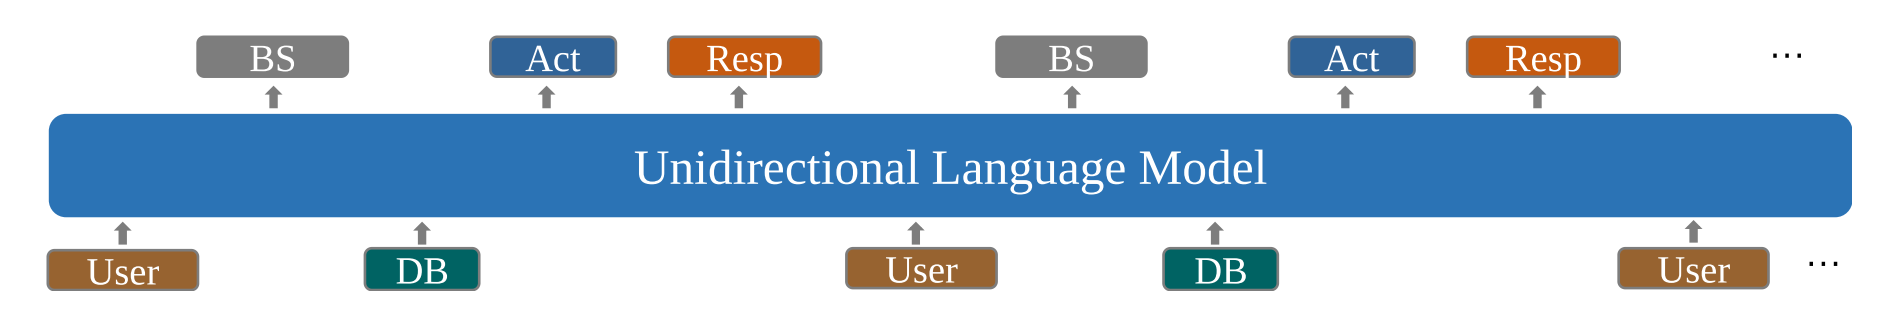

In [ ]:
%%capture
!pip install --upgrade openai
!pip install jsonlines

You can find your OpenAI API key [here](https://beta.openai.com/account/api-keys).


In [ ]:
import os
from getpass import getpass
import openai

openai.api_key = getpass('Enter OpenAI API key: ')

os.environ['OPENAI_API_KEY'] = openai.api_key

Enter OpenAI API key: ··········


The OpenAI API documentation has a [guide to fine-tuning models](https://beta.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with two key-value pairs: `prompt:` and `completion:`.

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
...
```

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
import itertools
import random
import json
import re


data_dir = Path(root_dir) / 'processed_multiwoz'
db = MultiWozDB(Path(root_dir) / 'MultiWOZ_2.1' / 'db') # for simulating database query


def constraint_to_dict(constraint):
    constraint_dict = {}
    domain = None
    last_match = None
    for match in re.finditer(r"\[(\w+)\]", constraint):
        if domain and last_match and re.match(r"\[value_[a-z]+\]", last_match.group(0)):
            slot = last_match.group(1)[6:]
            value = constraint[last_match.end():match.start()].strip()
            constraint_dict[domain][slot] = value

        if not re.match(r"\[value_[a-z]+\]", match.group(0)):
            if match.group(1) in ALL_DOMAINS:
                domain = match.group(1)
                constraint_dict[domain] = {}
            else:
                print('Invalid constraint token:', match.group(1))
                print('Constraint string:', constraint)

        last_match = match

    if domain and last_match and re.match(r"\[value_[a-z]+\]", last_match.group(0)):
        slot = last_match.group(1)[6:] # [value_name] -> name
        value = constraint[last_match.end():].strip()
        constraint_dict[domain][slot] = value

    return constraint_dict


def constraint_to_db_result(constraint, turn_domain):
    constraint_dict = constraint_to_dict(constraint)

    match_nums = db.get_match_num(constraint_dict)
    match_domain = turn_domain[0] if len(turn_domain) == 1 else turn_domain[1]
    match_domain = match_domain[1:-1] if match_domain.startswith("[") else match_domain
    match = match_nums[match_domain]
    return db.addDBIndicator(match_domain, match)[4:-1]


def create_finetuning_data(filename, max_dialogs=8433):
    fine_tuning_data = []

    with open(Path(data_dir) / 'train_data.json') as inp:
        data = json.load(inp)
    
    print("# dialogs in dataset:", len(data))

    for dialog in tqdm(data.values()):
        data = {}
        turn_strs = []
        for turn in dialog['log']:
            db_res = constraint_to_db_result(turn['constraint'], turn['turn_domain'].split())
            turn_strs.append(
                f"user: {turn['user']}\n" 
                f"state: {turn['constraint']}\n"
                f"match: {db_res}\n"
                f"action: {turn['sys_act']}\n"
                f"response: {turn['resp']}\n"
            )
        
        data['prompt'] = ''
        data['completion'] = '###\n'.join(turn_strs)
        fine_tuning_data.append(data)
    
    fine_tuning_data = random.sample(fine_tuning_data, k=max_dialogs)
    with open(filename, 'w') as out:
        for data in fine_tuning_data:
            out.write(json.dumps(data))
            out.write('\n')

In [ ]:
|jsonl_filename='fine_tune_multiwoz.jsonl'
create_finetuning_data(jsonl_filename, max_dialogs=8433)

!head '{jsonl_filename}' -n 10
!wc -lw '{jsonl_filename}'

# dialogs in dataset: 8433


  0%|          | 0/8433 [00:00<?, ?it/s]

{"prompt": "", "completion": "user: i need a place to eat that is cheap .\nstate: [restaurant] [value_pricerange] cheap\nmatch: 3\naction: [restaurant] [request] area\nresponse: does location matter ?\n###\nuser: yes , in the south , i am also looking for romanian food .\nstate: [restaurant] [value_pricerange] cheap [value_area] south [value_food] romanian\nmatch: 0\naction: [restaurant] [nooffer] [general] [reqmore]\nresponse: there are no restaurants that meet what you 're looking for . is there anything else you 'd like to try ?\n###\nuser: same area and price , but portuguese , anything for that ?\nstate: [restaurant] [value_pricerange] cheap [value_area] south [value_food] portuguese\nmatch: 1\naction: [restaurant] [nooffer]\nresponse: sorry i do n't have anything for that either .\n###\nuser: can you try chinese ?\nstate: [restaurant] [value_pricerange] cheap [value_area] south [value_food] chinese\nmatch: 1\naction: [restaurant] [nooffer]\nresponse: sorry i do n't have anything 

Next, we'll make the fine tuning API call via the command line.  Here the -m argument gives the model.  There are 4 sizes of GPT3 models.  They go in alphabetical order from smallest to largest.
* Ada 
* Baddage
* Currie
* Davinci

The models as the model sizes increase, so does their quality and their cost.  Davinci is the highest quality and highest cost model.  I recommend starting by fine-tuning smaller models to debug your code first so that you don't rack up costs.

Fine-tuning babbage on 8433 dialogues costs about $16.


In [ ]:
!openai api fine_tunes.create -t '{jsonl_filename}' -m babbage --n_epochs 4 --suffix "ubar"

Logging requires wandb to be installed. Run `pip install wandb`.
Upload progress: 100% 21.8M/21.8M [00:00<00:00, 40.4Git/s]
Uploaded file from fine_tune_multiwoz.jsonl: file-h6BXLKo2PRdW0M5QbnLbFe1a
Created fine-tune: ft-rLXdG9F7riQWgbMmaqYO7tVi
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-04-24 05:33:29] Created fine-tune: ft-rLXdG9F7riQWgbMmaqYO7tVi
[2022-04-24 05:33:48] Fine-tune costs $15.49
[2022-04-24 05:33:48] Fine-tune enqueued. Queue number: 0
[2022-04-24 05:33:52] Fine-tune started

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-rLXdG9F7riQWgbMmaqYO7tVi



In [ ]:
!openai api fine_tunes.cancel -i ft-BltVwDo5jw3kagGETnz64IvK

Logging requires wandb to be installed. Run `pip install wandb`.
{
  "created_at": 1650737164,
  "events": [
    {
      "created_at": 1650737165,
      "level": "info",
      "message": "Created fine-tune: ft-BltVwDo5jw3kagGETnz64IvK",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1650737180,
      "level": "info",
      "message": "Fine-tune costs $15.56",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1650737180,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 0",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1650737185,
      "level": "info",
      "message": "Fine-tune started",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1650738880,
      "level": "info",
      "message": "Completed epoch 1/4",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1650739490,
      "level": "info",
      "message": "Fine-tune cancelled",
      "object": "fine-tune-event"
  

In [ ]:
!openai api fine_tunes.follow -i ft-rLXdG9F7riQWgbMmaqYO7tVi

Logging requires wandb to be installed. Run `pip install wandb`.
[2022-04-24 05:33:29] Created fine-tune: ft-rLXdG9F7riQWgbMmaqYO7tVi
[2022-04-24 05:33:48] Fine-tune costs $15.49
[2022-04-24 05:33:48] Fine-tune enqueued. Queue number: 0
[2022-04-24 05:33:52] Fine-tune started
[2022-04-24 06:01:49] Completed epoch 1/4
[2022-04-24 06:29:06] Completed epoch 2/4
[2022-04-24 06:56:24] Completed epoch 3/4
[2022-04-24 07:23:36] Completed epoch 4/4
[2022-04-24 07:24:01] Uploaded model: babbage:ft-ccb-lab-members:ubar-2022-04-24-07-23-59
[2022-04-24 07:24:04] Uploaded result file: file-OZjsx8M3H2NUMw4pjqpeky4a
[2022-04-24 07:24:05] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m babbage:ft-ccb-lab-members:ubar-2022-04-24-07-23-59 -p <YOUR_PROMPT>


In [ ]:
from pathlib import Path
from pprint import pprint
import string
import random
import spacy
from sacremoses import MosesTokenizer, MosesDetokenizer
from collections import deque, defaultdict


# generate_response_model = "babbage:ft-ccb-lab-members:ubar-2022-04-24-07-23-59"
generate_response_model = "babbage:ft-ccb-lab-members:ubar-2022-04-24-00-56-30" # better

db = MultiWozDB(Path(root_dir) / 'MultiWOZ_2.1' / 'db') # for simulating database query


def fill_entities(resp, constraint, turn_domain):
    """Fill in placeholders based on DB queries. This does not always make sense since
    it does not consider sentence structure and dialog context.
    `[value_reference]` is not stored in DB so it's randomly generated.
    """
    constraint_dict = constraint_to_dict(constraint)
    entries = db.get_match_num(constraint_dict, return_entry=True)
    if len(constraint_dict) == 0:
        return resp.replace('[value_choice]', 'many')
    
    for domain in turn_domain:
        domain = domain[1:-1] if domain.startswith('[') else domain
        if domain == 'general':
            continue

        entity_slots = set(ENTITY_SLOTS[domain])
        entities = entries.get(domain, list())
        random.shuffle(entities) # shuffle so system doesn't always recommend the same entity
        # pprint(entities)

        vals_by_slot = defaultdict(list)
        for slot in entity_slots:
            seen = set()
            for entity in entities:
                if slot in entity and slot not in seen:
                    vals_by_slot[slot].append(entity[slot])
                    seen.add(entity[slot])
        
        vals_by_slot_iter = {slot: iter(vals) for slot, vals in vals_by_slot.items()}
        sents = []
        for sent in resp.split(' . '): # each [value_choice] should only cover inside sentence boundary
            fill_map = {}
            last_choice_match = None
            choice_constraints = None
            for slot_match in re.finditer("\[value_([a-z]+)\]", sent):
                slot = slot_match.group(1)
                
                if slot == 'choice':
                    if last_choice_match:
                        choice = 0
                        for entity in entities:
                            if all(entity[slot] == val for slot, val in choice_constraints.items()):
                                choice += 1
                        fill_map[last_choice_match.span()] = str(choice) if choice < 10 else 'many'
                    choice_constraints = {}
                    last_choice_match = slot_match
                elif slot == 'reference':
                    rand_ref = ''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(8))
                    fill_map[slot_match.span()] = rand_ref
                elif slot in vals_by_slot:
                    try:
                        val = next(vals_by_slot_iter[slot])
                    except StopIteration:
                        # wrap around and reset generator
                        vals_by_slot_iter[slot] = iter(vals_by_slot[slot])
                        val = next(vals_by_slot_iter[slot])
                    fill_map[slot_match.span()] = val
                    if choice_constraints is not None and slot in ENTITY_SLOTS[domain]:
                    # if choice_constraints is not None and slot in INFORMABLE_SLOTS[domain]:
                        choice_constraints[slot] = val
                elif domain in constraint_dict and slot in constraint_dict[domain]:
                    fill_map[slot_match.span()] = constraint_dict[domain][slot]
            
            if last_choice_match:
                choice = 0
                for entity in entities:
                    if all(entity[slot] == val for slot, val in choice_constraints.items()):
                        choice += 1
                fill_map[last_choice_match.span()] = str(choice) if choice < 10 else 'many'

            sent = list(sent)
            for span, val in fill_map.items():
                for i in range(*span):
                    sent[i] = ''
                sent[span[0]] = val
            sents.append(''.join(sent))
        resp = ' . '.join(sents)
    return resp


def predict_slots_batch(contexts, utterances):
    context_strs = ['###\n'.join(context) for context in contexts]

    curr_turns = [(
        f"user: {utterance}\n"
        f"state:"
    ) for utterance in utterances]

    prompts = [f"{context}###\n{curr_turn}" if context != '' else curr_turn
               for context, curr_turn in zip(context_strs, curr_turns)]

    response = openai.Completion.create(
        model=generate_response_model,
        prompt=prompts,
        temperature=0.7,
        max_tokens=128,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["\n"]
    )

    slots = [ret['text'].strip() for ret in response['choices']]
    return slots


def generate_response_batch(contexts, utterances, domains, slots=None, budget=1, fill_entity=False):
    """Generate a list of responses given a list of contexts, user utterances, domains, and optionally slots.
    Batch improves inference speed. Note domains are 2D list b/c 1 turn may have more than 1 domains.
    """
    if slots is None:
        slots = predict_slots_batch(contexts, utterances)

    db_results = [constraint_to_db_result(s, d) for s, d in zip(slots, domains)] # query Database
    context_strs = ['###\n'.join(context) for context in contexts]

    curr_turns = [(
        f"user: {utterance}\n"
        f"state: {slots}\n"
        f"match: {db_res}\n"
        f"action:"
    ) for utterance, slots, db_res in zip(utterances, slots, db_results)]

    prompts = [f"{context}###\n{curr_turn}" if context != '' else curr_turn
               for context, curr_turn in zip(context_strs, curr_turns)]

    # Generate actions and responses
    response = openai.Completion.create(
        model=generate_response_model,
        prompt=prompts,
        temperature=0.7,
        max_tokens=200,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        n=budget,
        stop=["\n###\n"]
    )

    act_resps = [ret['text'].strip() for ret in response['choices']]
    resps = []
    for i, act_resp in enumerate(act_resps):            
        try:
            resps.append(act_resp.split('response:')[1].strip())
        except:
            print('Invalid action & response:', act_resp)
            print(curr_turns[i // budget])
            print(contexts[i // budget])
            resps.append('')

    new_curr_turns = []
    for i, curr_turn in enumerate(curr_turns):
        for j in range(budget):
            new_curr_turns.append(f"{curr_turn} {act_resps[i * budget + j]}\n")

    if fill_entity:
        slots = itertools.chain.from_iterable(itertools.repeat(s, budget) for s in slots)
        domains = itertools.chain.from_iterable(itertools.repeat(d, budget) for d in domains)
        resps = [fill_entities(resp, slots, domain)
                 for resp, slots, domain in zip(resps, slots, domains)]

    return resps, new_curr_turns


def interactive_dialog(domain, context_window=10, fill_entity=True):
    """Launch interactive dialog session, enter exit to exit
    Note `fill_entity` does not always make sense b/c filled responses are
    not fed into the model in the dialog context.
    """
    nlp = spacy.load("en_core_web_sm")
    mt, md = MosesTokenizer(lang='en'), MosesDetokenizer(lang='en')
    
    context = deque(maxlen=context_window)
    while True:
        utterance = input(f'user: ').lower()
        # make sure we tokenize utterance like training
        utterance = ' '.join(t.text for t in nlp(utterance))
        utterance = ' '.join(utterance.replace(".", " . ").split())
        if utterance == 'exit':
            break

        resps, curr_turns = generate_response_batch([context], [utterance], [[domain]],
                                                    fill_entity=fill_entity)
        context.append(curr_turns[0]) # update context
        # detokenize response
        detokenized_resp = md.detokenize(mt.tokenize(resps[0],
                                                     protected_patterns=['value_', ']-', ']s', ']ly']))
        print(f"system: {detokenized_resp}")

    print("\n====== context ======\n\n" + '\n'.join(context))


In [ ]:
# resp = "we have [value_name]. [value_name] is good . Ref number is [value_reference]"
# slots = "[hotel] [value_name] acorn guest house "
# turn_domain = ['[hotel]', '[restaurant]']

# from pprint import pprint
# fill_entities(resp, slots, turn_domain)

'we have acorn guest house. acorn guest house is good . Ref number is gx3vfw5o'

## Interactive Interface
Good for error analysis

In [ ]:
interactive_dialog('restaurant')

user: can you recommend some place to eat
system: sure, what type of food are you looking for?
user: chinese
system: there are many chinese restaurants, what price range are you looking for?
user: moderate
system: there are 1 chinese restaurants in north. do you have a particular area in mind?
user: No, what is the name
system: shanghai family restaurant is a nice place.
user: Can you recommend another one
system: lan hong house is another option. can i give you their address?
user: sure book it please for 2 people
system: what day and time are you looking to book?
user: tuesday 2 pm
system: what day would you like it for?
user: I said tuesday
system: i was able to book that for you for 2 people on tuesday at 2pm. your reference number is: [value_reference]. is there anything else i can help you with?
user: exit

====== context ======

user: can you recommend some place to eat
state: 
match: null
action: [restaurant] [request] food
response: sure , what type of food are you looking for

In [ ]:
interactive_dialog('hotel')

user: I want a place to live for 2 days
system: sure. where are you looking for a guesthouse? do you have a price range in mind?
user: I'm looking for a hotel actually, not guesthouse. And i want to save money if possible
system: what part of town do you prefer?
user: anywhere is fine as long as it's cheap
system: the cambridge belfry is an cheap hotel in the west. would you like me to book you a room?
user: yes please for 1 person
system: what day will you be checking in?
user: monday
system: i will get the booking and then give you a call back
user: sounds good
system: okay i have booked that for you. your reservation number is [value_reference]. anything else i can help you with?
user: exit

====== context ======

user: i want a place to live for 2 days
state: [hotel] [value_stay] 2
match: 3
action: [hotel] [request] pricerange
response: sure . where are you looking for a [value_type] ? do you have a price range in mind ?

user: i 'm looking for a hotel actually , not guesthouse . a

In [ ]:
interactive_dialog('general')

user: hello
system: happy to help! what can i help you find?
user: I want a place to eat
system: what kind of food are you looking for?
user: expensive food
system: i am sorry, i have no listings for that. would you like to try a different type of food?
user: no 
system: is there anything else you would like to know?
user: no bye
system: goodbye.
user: exit

====== context ======

user: hello
constraint: 
database: [db_null]
action: [general] [reqmore]
response: happy to help ! what can i help you find ?

user: I want a place to eat
constraint: 
database: [db_null]
action: [restaurant] [request] food
response: what kind of food are you looking for ?

user: expensive food
constraint: [restaurant] [value_food] dontcare [value_pricerange] expensive
database: [db_null]
action: [restaurant] [nooffer] [request] food
response: i am sorry , i have no listings for that . would you like to try a different type of food ?

user: no
constraint: [restaurant] [value_food] dontcare [value_pricerange] 

# Neuro-Symbolic System 2

## User Action Parser

We want to parse user actions given the current utterance and the last system response. Feeding in last constraint might also help because a user might be setting a slot that refers to a value in the last state, e.g. taxi `[value_departure]` and `[value_destination]` when user says "I want a taxi from the restaurant to the hotel."

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
import random
import json


data_dir = Path(root_dir) / 'processed_multiwoz'


def create_utterance_parser_ft_data(filename, max_samples=56745):
    fine_tuning_data = []

    with open(Path(data_dir) / 'train_data.json') as inp:
        data = json.load(inp)

    for dialog in tqdm(data.values()):
        last_resp = None
        for turn in dialog['log']:
            data = {}
            data['prompt'] = (
                f"agent: {last_resp}\n" 
                f"user: {turn['user']}\n\n###\n\n"
            )
            data['completion'] = f" {turn['user_act']} END"

            fine_tuning_data.append(data)
            last_resp = turn['nodelx_resp']

    print("# samples in dataset:", len(fine_tuning_data))
    
    fine_tuning_data = random.sample(fine_tuning_data, k=max_samples)
    with open(filename, 'w') as out:
        for data in fine_tuning_data:
            out.write(json.dumps(data))
            out.write('\n')

In [ ]:
jsonl_filename='fine_tune_user_parser.jsonl'
create_utterance_parser_ft_data(jsonl_filename, max_samples=56745)

!head '{jsonl_filename}'
!wc -lw '{jsonl_filename}'

  0%|          | 0/8433 [00:00<?, ?it/s]

# samples in dataset: 56745
{"prompt": "agent: None\nuser: i am looking for a place to stay , i would prefer a hotel .\n\n###\n\n", "completion": " [hotel] [inform] [value_type] hotel END"}
{"prompt": "agent: where will you be traveling to ?\nuser: i will be going to broxbourne .\n\n###\n\n", "completion": " [train] [inform] [value_destination] broxbourne END"}
{"prompt": "agent: the place is a nightclub in the south .\nuser: which nightclub is it ? and can you get me the information on it ?\n\n###\n\n", "completion": " [attraction] [inform] [value_name] the place END"}
{"prompt": "agent: there are two options for you . royal spice and da vinci pizzeria . do you have a preference ?\nuser: let 's try the da vinci pizzeria . i 'll need the address and phone number too , please .\n\n###\n\n", "completion": " [restaurant] [inform] [value_name] da vinci pizzeria [request] [value_address] [value_phone] END"}
{"prompt": "agent: i have 2 choices . the lucky star serves chinese . and , nando 's

In [ ]:
!openai api fine_tunes.create -t '{jsonl_filename}' -m ada --n_epochs 4 --suffix "user parser"

Logging requires wandb to be installed. Run `pip install wandb`.
Upload progress: 100% 14.4M/14.4M [00:00<00:00, 24.0Git/s]
Uploaded file from fine_tune_user_parser.jsonl: file-ffwh3Z42AzTJ7tT4JOhKnRuH
Created fine-tune: ft-ZgqUkOHaZmXzhfTcemDnT7ma
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-04-27 22:14:11] Created fine-tune: ft-ZgqUkOHaZmXzhfTcemDnT7ma
[2022-04-27 22:14:38] Fine-tune costs $5.59
[2022-04-27 22:14:38] Fine-tune enqueued. Queue number: 0
[2022-04-27 22:17:12] Fine-tune started

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-ZgqUkOHaZmXzhfTcemDnT7ma



In [ ]:
!openai api fine_tunes.follow -i ft-ZgqUkOHaZmXzhfTcemDnT7ma

Logging requires wandb to be installed. Run `pip install wandb`.
[2022-04-27 22:14:11] Created fine-tune: ft-ZgqUkOHaZmXzhfTcemDnT7ma
[2022-04-27 22:14:38] Fine-tune costs $5.59
[2022-04-27 22:14:38] Fine-tune enqueued. Queue number: 0
[2022-04-27 22:17:12] Fine-tune started
[2022-04-27 22:24:37] Completed epoch 1/4
[2022-04-27 22:31:31] Completed epoch 2/4
[2022-04-27 22:38:21] Completed epoch 3/4
[2022-04-27 22:45:11] Completed epoch 4/4
[2022-04-27 22:45:29] Uploaded model: ada:ft-ccb-lab-members:user-parser-2022-04-27-22-45-28
[2022-04-27 22:45:32] Uploaded result file: file-rm9KvRGTZtTVhaTsl1bo3Bz1
[2022-04-27 22:45:33] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-ccb-lab-members:user-parser-2022-04-27-22-45-28 -p <YOUR_PROMPT>


In [ ]:
from itertools import chain
import re


parse_user_acts_model = "ada:ft-ccb-lab-members:user-parser-2022-04-27-22-45-28" # better
# parse_user_acts_model = "ada:ft-ccb-lab-members:user-parser-2022-04-25-07-24-01"


def nodelx_act_to_dict(nodelx_act, user=True):
    """Convert nodelexed action with action, slot, value triplets to dict.
    This function can also be used for system act if it is not delexed.
    If a slot have no value, `?` is used as the value.
    """
    allowed_acts = set(USER_ACTIONS if user else chain.from_iterable(SYSTEM_ACTIONS.values()))

    act_dict = {}
    domain, action, slot = None, None, None
    last_match = None
    # Iterate over special tokens
    for match in re.finditer(r"\[(\w+)\]", nodelx_act):
        if domain and action and slot and last_match and last_match.group(1) == slot:
            slot = last_match.group(1)[6:] # [value_name] -> name
            value = nodelx_act[last_match.end():match.start()].strip()
            value = '?' if value == '' else value
            act_dict[domain][action][slot] = value

        if re.match(r"\[value_[a-z]+\]", match.group(0)):
            if action:
                slot = match.group(1)
        elif match.group(1) in allowed_acts:
            if domain:
                action = match.group(1)
                act_dict[domain][action] = {}
        elif match.group(1) in ALL_DOMAINS + ['general']:
            domain = match.group(1)
            act_dict[domain] = {}
        else:
            role = 'user' if user else 'system'
            print(f'Invalid {role} act token:', match.group(1))
            print('Action string:', nodelx_act)

        last_match = match

    if domain and action and slot and last_match and last_match.group(1) == slot:
        slot = last_match.group(1)[6:] # [value_name] -> name
        value = nodelx_act[last_match.end():].strip()
        value = '?' if value == '' else value
        act_dict[domain][action][slot] = value

    return act_dict


def parse_user_acts_batch(last_resps, utterances):
    prompts = [(
        f"agent: {last_resp}\n"
        f"user: {utterance}\n\n###\n\n"
    ) for last_resp, utterance in zip(last_resps, utterances)]

    response = openai.Completion.create(
        model=parse_user_acts_model,
        prompt=prompts,
        temperature=1.0,
        max_tokens=64,
        top_p=0.2,
        frequency_penalty=0,
        presence_penalty=0,
        stop=[" END"]
    )
    # print(response['choices'][0]['text'].strip())

    actions = [nodelx_act_to_dict(ret['text'].strip(), user=True)
               for ret in response['choices']]
    return actions

In [ ]:
nodelx_act_to_dict('[hotel] [inform] [value_address] [request] [value_name]')

{'hotel': {'inform': {'address': '?'}, 'request': {'name': '?'}}}

In [ ]:
# last_slots = "[hotel] [value_area] south [value_stars] 4 [value_parking] yes [value_pricerange] cheap [value_name] rosa's [value_type] guesthouse [value_day] wednesday [value_people] 2 [value_stay] 2 [restaurant] [value_name] maharajah tandoori [value_day] wednesday [value_people] 2 [value_time] 11:45"
# utterance = "i need a taxi to the restaurant ."

# last_slots = "[hotel] [value_area] south [value_stars] 4 [value_parking] yes [value_pricerange] cheap [value_name] rosa's [value_type] guesthouse [value_day] wednesday [value_people] 2 [value_stay] 2"
# utterance = "I want a chinese place to dine."

# last_slots = None
# utterance = "sure. just a moment."

# last_resp = "there are 9 that fit your request . may i suggest the acorn guest house ? it 's a nice place to stay ."
# utterance = "that 's a guesthouse right ? could you give me it 's address and star rating ?"

# last_resp = None
# utterance = "i am looking for a guesthouse to stay in with free wifi ."

# last_resp = "we have 23 guesthouses in cambridge that include internet . would you like to narrow it down by area , rating , or price range at all ?"
# utterance = "yes , i would like a moderately priced place in the north ."

# last_resp = "7 places still have that , can i suggest the acorn guest house for you ?"
# utterance = "can i get the postcode of that place ?"

# last_resp = "i have two pools in the north area of town : jesus green outdoor pool and kings hedges learner pool . which do you prefer ?"
# utterance = "kings hedges sounds nice . can i get the address please ?"

# last_resp = "i have 5 expensive places to stay . how about one in the town centre ?"
# utterance = "sure , it should have free parking and have 4 stars ."

# User rejection not considered
# last_resp = "how about acorn guest house ?"
# utterance = "no I hate that place . "

# Not enough domain info
# last_resp = "can i go ahead and book this for you ?"
# utterance = "no , i just need their address ."

# Complex multi-domain parsing not working well, potential future work: parse domains first then generate actions for each domain
last_resp = "i have the archway house , it is a guesthouse in the moderate price range and has free parking ."
utterance = "what is the full phone number and area code of the archway house ? also , is there a persian restaurant near the centre of the location ?"

# last_resp = "the phone number is 01223575314 . what price range would you like the persian restaurant to be ?"
# utterance = "also expensive . may i have the post code and area of the archway house as well ?"

parse_user_acts_batch([last_resp], [utterance])[0]

{'hotel': {'inform': {'name': 'archway house'},
  'request': {'area': '?', 'persian': '?', 'phone': '?'}}}

## System Action Parser

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
import random
import json


data_dir = Path(root_dir) / 'processed_multiwoz'


def create_response_parser_ft_data(filename, max_samples=56745):
    fine_tuning_data = []

    with open(Path(data_dir) / 'train_data.json') as inp:
        data = json.load(inp)

    for dialog in tqdm(data.values()):
        for turn in dialog['log']:
            data = {}
            data['prompt'] = (
                f"user: {turn['user']}\n" 
                f"agent: {turn['resp']}\n\n###\n\n"
            )
            data['completion'] = f" {turn['sys_act']} END"

            fine_tuning_data.append(data)

    print("# samples in dataset:", len(fine_tuning_data))
    
    fine_tuning_data = random.sample(fine_tuning_data, k=max_samples)
    with open(filename, 'w') as out:
        for data in fine_tuning_data:
            out.write(json.dumps(data))
            out.write('\n')

In [ ]:
jsonl_filename='fine_tune_agent_parser.jsonl'
create_response_parser_ft_data(jsonl_filename, max_samples=56745)

!head '{jsonl_filename}'
!wc -lw '{jsonl_filename}'

  0%|          | 0/8433 [00:00<?, ?it/s]

# samples in dataset: 56745
{"prompt": "user: i like you no problem .\nagent: thanks for using our service today !\n\n###\n\n", "completion": " [general] [bye] END"}
{"prompt": "user: that does not matter but i want it to have 4 stars .\nagent: i would recommend the [value_name] , would you like me to book you ?\n\n###\n\n", "completion": " [hotel] [recommend] name [offerbook] END"}
{"prompt": "user: thank you . i also want a hotel to stay which should a have a star of 4\nagent: what area would you like to stay in ?\n\n###\n\n", "completion": " [hotel] [request] area END"}
{"prompt": "user: i actually do nt need a reservation . just the address , postcode and phone number please .\nagent: they are located [value_address] , [value_postcode] . phone : [value_phone] .\n\n###\n\n", "completion": " [restaurant] [inform] address phone postcode END"}
{"prompt": "user: thank you for your help .\nagent: is there anything else i can help you with today ?\n\n###\n\n", "completion": " [general] [r

In [ ]:
!openai api fine_tunes.create -t '{jsonl_filename}' -m ada --n_epochs 4 --suffix "agent parser"

Logging requires wandb to be installed. Run `pip install wandb`.
Upload progress: 100% 14.3M/14.3M [00:00<00:00, 23.7Git/s]
Uploaded file from fine_tune_agent_parser.jsonl: file-NLPYLR6O50PaalmxrPghhy8l
Created fine-tune: ft-sUTWaRhNBngIhADEqVZgxjzi
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-04-27 22:55:53] Created fine-tune: ft-sUTWaRhNBngIhADEqVZgxjzi
[2022-04-27 22:56:14] Fine-tune costs $5.46
[2022-04-27 22:56:14] Fine-tune enqueued. Queue number: 0

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-sUTWaRhNBngIhADEqVZgxjzi



In [ ]:
!openai api fine_tunes.follow -i ft-sUTWaRhNBngIhADEqVZgxjzi

Logging requires wandb to be installed. Run `pip install wandb`.
[2022-04-27 22:55:53] Created fine-tune: ft-sUTWaRhNBngIhADEqVZgxjzi
[2022-04-27 22:56:14] Fine-tune costs $5.46
[2022-04-27 22:56:14] Fine-tune enqueued. Queue number: 0
[2022-04-27 23:04:02] Fine-tune started
[2022-04-27 23:11:47] Completed epoch 1/4
[2022-04-27 23:18:12] Completed epoch 2/4
[2022-04-27 23:24:34] Completed epoch 3/4
[2022-04-27 23:30:58] Completed epoch 4/4
[2022-04-27 23:31:17] Uploaded model: ada:ft-ccb-lab-members:agent-parser-2022-04-27-23-31-15
[2022-04-27 23:31:20] Uploaded result file: file-zgeMWw95n5P6ejaEDBhQ1Q6Y
[2022-04-27 23:31:21] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-ccb-lab-members:agent-parser-2022-04-27-23-31-15 -p <YOUR_PROMPT>


In [ ]:
import re


parse_system_acts_model = "ada:ft-ccb-lab-members:agent-parser-2022-04-27-23-31-15" # better
# parse_system_acts_model = "ada:ft-ccb-lab-members:agent-parser-2022-04-26-05-08-50"


def delexed_act_to_dict(delexed_act, user=False):
    """Convert delexed action with action, slot pairs to dict.
    """
    allowed_acts = set(USER_ACTIONS if user else chain.from_iterable(SYSTEM_ACTIONS.values()))
    
    act_dict = {}
    domain = None
    action = None
    last_match = None
    # Iterate over special tokens
    for match in re.finditer(r"\[(\w+)\]", delexed_act):
        if domain and action and last_match and last_match.group(1) == action:
            slots = delexed_act[last_match.end():match.start()].split()
            act_dict[domain][action].update(slots)

        if match.group(1) in allowed_acts:
            if domain:
                action = match.group(1)
                act_dict[domain][action] = set()
        elif match.group(1) in ALL_DOMAINS + ['general']:
            domain = match.group(1)
            act_dict[domain] = {}
        else:
            role = 'user' if user else 'system'
            print(f'Invalid {role} act token:', match.group(1))
            print('Action string:', delexed_act)

        last_match = match

    if domain and action and last_match and last_match.group(1) == action:
        slots = delexed_act[last_match.end():].split()
        act_dict[domain][action].update(slots)

    return act_dict


def parse_system_acts_batch(user_queries, responses):
    prompts = [(
        f"user: {user_query}\n"
        f"agent: {response}\n\n###\n\n"
    ) for user_query, response in zip(user_queries, responses)]

    response = openai.Completion.create(
        model=parse_system_acts_model,
        prompt=prompts,
        temperature=1.0,
        max_tokens=64,
        top_p=0.2,
        frequency_penalty=0,
        presence_penalty=0,
        stop=[" END"]
    )
    # print(response['choices'][0]['text'].strip())

    actions = [delexed_act_to_dict(ret['text'].strip(), user=False)
               for ret in response['choices']]
    
    return actions

In [ ]:
utterance = "i want to book a table for 4 people at 15:00 on wednesday . please give me a reference number ."
response = "sure thing ! your reference number is [value_reference] . can i help you with anything else today ?"

# Is domain prediction reliable when there is no info?
# utterance = "that 's perfect , thanks !"
# response = "can i go ahead and book this for you ?"

# utterance = "hello , i want a nice place to dine ."
# response = "in what area ?"

parse_system_acts_batch([utterance], [response])[0] 

{'general': {'reqmore': set()}, 'restaurant': {'offerbooked': {'reference'}}}

## Schema for Belief State
IMPORTANT: When adding a rule, you must make sure it improves scores on the dev set in the A/B test eval section below

In [ ]:
from pathlib import Path
from collections import defaultdict
from itertools import chain
import json


db = MultiWozDB(Path(root_dir) / 'MultiWOZ_2.1' / 'db')


class ValidationError(Exception):
    pass

class InputError(Exception):
    '''When user's input is out of range. Should let user retype another utterance'''
    pass


class BeliefState:
    SCHEMA_DOMAINS = ['restaurant', 'hotel']
    SYS_INFO_ACTS = {'inform', 'recommend', 'offerbook', 'offerbooked'}
    SYS_REQ_ACTS = {'request', 'select'}

    def __init__(self):
        # user informed slot, value pair per domain
        self.info_state = defaultdict(dict)
        # user requested slots per domain
        self.req_state = defaultdict(set)
        self.active_domains = ['general']
        self.failed_bookings = set()
        self.user_act = None

    def update_user(self, user_act):
        user_act = defaultdict(dict, user_act)
        self.user_act = user_act
        # Update active domains
        turn_domains = [domain for domain in user_act
                        if domain in self.SCHEMA_DOMAINS + ['general']]
        # print("turn_domains", turn_domains)
        # print("active_domains", self.active_domains)
        # print("user_act", user_act)
        if len(turn_domains) == 2 and 'general' in turn_domains:
            turn_domains.remove('general')
        if (len(turn_domains) == 2 and len(self.active_domains) == 1
            # keep current domain the last one if there are multiple active
            and self.active_domains[0] == turn_domains[1]):
            turn_domains = turn_domains[::-1]
        if len(turn_domains) > 0:
            self.active_domains = turn_domains

        # Update info_state and req_state
        for domain in turn_domains:
            # print("domain", domain)
            if 'inform' in user_act[domain]:
                for slot, val in user_act[domain]['inform'].items():
                    if slot in INFORMABLE_SLOTS[domain]:
                        if val == '?':
                            print(f'[{domain}] user informed slot has no value:', slot)
                            print(user_act)
                            continue
                        if (slot in CATEGORICAL_SLOTS[domain]
                            and val not in CATEGORICAL_SLOTS[domain][slot] + ['unknown', 'dontcare']): 
                            print(f'[{domain}] user informed categorical slot value out of range: {slot}={val}')
                            print(user_act)
                            continue
                        else:
                            self.info_state[domain][slot] = val
                    else:
                        print(f'[{domain}] user informed slot out of range:', slot)
                        print(user_act)
            if 'request' in user_act[domain]:
                for slot in user_act[domain]['request']:
                    if slot in REQUESTABLE_SLOTS[domain]:
                        self.req_state[domain].add(slot)
                    else:
                        print(f'[{domain}] user requested slot out of range:', slot)
                        print(user_act)
        
        # print("self.info_state", self.info_state)
        # print("self.req_state", self.req_state)

    def update_system(self, system_act, force=False):
        system_act = defaultdict(dict, system_act)
        valid, reason = self.check_validity(system_act)

        # Remove system informed slots from req_state
        # Uninformed ones can be informed in the next turn
        for domain in self.active_domains:
            for act, slots in system_act[domain].items():
                if act in self.SYS_INFO_ACTS:
                    self.req_state[domain].difference_update(slots)
        
        if not valid and not force:
            raise ValidationError(reason)
        
    def check_validity(self, system_act):
        # Query # DB match based on informed slots
        curr_domain = self.active_domains[-1]
        # curr_domain = curr_domain[1:-1] if curr_domain.startswith("[") else curr_domain
        db_match = db.get_match_num(self.info_state)[curr_domain]
        
        # print("system_act", system_act)
        # print("self.info_state", self.info_state)
        # print("self.req_state", self.req_state)
        # print("db_match", db_match)

        # System switched domain from user domain, but it's okay if one is general domain
        if (curr_domain not in system_act
            and 'general' not in system_act
            and curr_domain != 'general'):
            return False, 'System switched domain'  

        for domain in self.active_domains:
            if domain == 'general':
                if 'bye' in system_act[domain]:
                    if not 'bye' in self.user_act[domain]:
                      return False, 'The user need to end the conversation first'
                if 'greet' in system_act[domain]:
                    pass  # TODO
                if 'reqmore' in system_act[domain]:
                    pass  # TODO
                if 'thank' in system_act[domain]:
                    pass  # TODO
                if 'welcome' in system_act[domain]:
                    if not 'thank' in self.user_act[domain]:
                      return False, 'The user did not express gratitude'
            else:
                # Retrieve all slots informed by system
                sys_info_slots = set(chain.from_iterable(slots for act, slots in system_act[domain].items()
                                     if act in self.SYS_INFO_ACTS))

                # slot is requested by user but not informed by system
                if not self.req_state[domain].issubset(sys_info_slots):
                    return False, 'Did not inform user with a slot user requested'
                elif self.req_state[domain] < sys_info_slots:
                    # system informed something that user doesn't ask. do we need to do anything?
                    pass

                # Retrieve all slots requested by system
                sys_req_slots = set(chain.from_iterable(slots for act, slots in system_act[domain].items()
                                    if act in self.SYS_REQ_ACTS))

                for slot, val in self.info_state[domain].items():
                    if val == 'unknown':
                        if slot not in sys_req_slots:
                            return False, 'Did not request an unknown slot from user'
                    else:
                        if slot in sys_req_slots and db_match > 0:
                            return False, 'Requesting a slot that is already filled'
                        # if (slot == 'name' and val != 'dontcare'
                        #     and any(s in sys_req_slots for s in ENTITY_SLOTS[domain])):
                        #     return False, 'Requesting an entity slot that is entailed'
                
                # TODO: implement mechanism to relax constraint when there is no match or availability
                # TODO: also see if narrowing down entries by requesting important slots helps.
                # Some actions to consider: select, request, recommend

                # TODO: offerbooked when there is no booking availability
                # TODO: nobook when there is booking availability

                if 'recommend' in system_act[domain]:
                    pass # TODO
                if 'select' in system_act[domain]:
                    pass
                # Offerbook if there is no database match
                if 'offerbook' in system_act[domain]:
                    # db_match is empty string when domain not in info_state
                    if db_match == '' or db_match == 0:  
                        return False, 'Offerbook but there is no database match'
                    if 'nooffer' in system_act[domain]:  
                        return False, 'Offerbook and nooffer at the same time'
                # Nooffer when there are database matches
                if 'nooffer' in system_act[domain]:
                    # db_match is empty string when domain not in info_state or domain is general
                    if db_match == '' or db_match > 0:  
                        return False, 'Nooffer when there are database matches'
                    if 'offerbook' in system_act[domain]:  
                        return False, 'Offerbook and nooffer at the same time'
                # Offerbook if there is no database match
                if 'offerbooked' in system_act[domain]:
                    # db_match is empty string when domain not in info_state
                    if db_match == '' or db_match == 0:  
                        return False, 'Offerbook but there is no database match'
                    if 'nobook' in system_act[domain]:  
                        return False, 'Offerbooked and nobook at the same time'
                if 'nobook' in system_act[domain]:
                    if 'offerbooked' in system_act[domain]:  
                        return False, 'Offerbooked and nobook at the same time'
                
                # Consistent so far
                # Reject if this booking failed before but is available now
                #print(self.serialize(domain = domain))
                if 'offerbook' in system_act[domain] or 'offerbooked' in system_act[domain]:
                  if self.serialize(domain = domain) in self.failed_bookings:
                    return False, 'This booking has failed previously.'
                # Record this booking if no offer is made
                if 'nooffer' in system_act[domain]:
                  self.failed_bookings.add(self.serialize(domain = domain))
        return True, 'success'

    def serialize(self, domain = None):
        """Convert informed slots to string
        """
        serialized = []
        info_state = self.info_state[domain] if not domain==None else self.info_state
        for domain, state in info_state.items():
            if len(state) > 0:
                serialized.append(f'[{domain}]')
                if (type(state) is str):
                  serialized.append(state)
                else:
                  for slot, val in state.items():
                      serialized.append(f'[value_{slot}] {val}')
        return ' '.join(serialized)


## Unit Tests

In [ ]:
def unit_test_schema(user_acts, system_act):
    """Unit test belief state schema
    """
    belief_state = BeliefState()
    print("--------------------------------------")
    print("user_acts", user_acts)
    belief_state.update_user(user_acts)
    print("belief_state", belief_state.serialize())

    print("system_acts", system_act)
    try:
        belief_state.update_system(system_act)
        return "no error"
    except Exception as e:
        return str(e)

# valid
user_acts1 = {'restaurant': {'inform': {'food': 'chinese'}}}
system_act1 = {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'pricerange': '?'}}}
expected = 'no error'
result = unit_test_schema(user_acts1, system_act1)
print('test1', 'passed' if result == expected else 'failed: ' + result) 

# user requested name but system doesn't inform name
user_acts2 = {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'name': '?'}}}
system_act2 = {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'pricerange': '?'}}}
expected = 'Did not inform user with a slot user requested'
result = unit_test_schema(user_acts2, system_act2)
print('test2', 'passed' if result == expected else 'failed: ' + result) 

# user requested name but system doesn't inform name
user_acts3 = {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'name': '?'}}}
system_act3 = {'restaurant': {'inform': {'food': 'chinese', 'name': 'hakka'}, 'request': {'pricerange': '?'}}}
expected = 'no error'
result = unit_test_schema(user_acts3, system_act3)
print('test3', 'passed' if result == expected else 'failed: ' + result) 

# offerbook when there is no db match for user act
# Expected: err - Offerbook but there is no database match
user_acts4 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}}}
system_act4 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}, 'offerbook': {}}}
expected = 'Offerbook but there is no database match'
result = unit_test_schema(user_acts4, system_act4)
print('test4', 'passed' if result == expected else 'failed: ' + result) 

# pricerange is unknown so it's okay for system to ask
user_acts5 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'unknown'}}}
system_act5 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}, 'request': {'pricerange': '?'}}}
expected = 'no error'
result = unit_test_schema(user_acts5, system_act5)
print('test5', 'passed' if result == expected else 'failed: ' + result)  

# user_acts6 = {'hotel': {'inform': {'name': 'acorn guest house'}}}
# system_act6 = {'hotel': {'request': {'area', 'people'}}}
# expected = 'Requesting an entity slot that is entailed'
# result = unit_test_schema(user_acts6, system_act6)
# print('test6', 'passed' if result == expected else 'failed: ' + result) 

# not ok to switch domain from restaurant to hotel
user_acts7 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'unknown'}}}
system_act7 = {'hotel': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}, 'request': {'pricerange': '?'}}}
expected = 'System switched domain'
result = unit_test_schema(user_acts7, system_act7)
print('test7', 'passed' if result == expected else 'failed: ' + result) 

# ok to switch domain from restaurant to general
user_acts8 = {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'cheap'}}}
system_act8 = {'general': {'bye': {}}}
expected = 'no error'
result = unit_test_schema(user_acts8, system_act8)
print('test8', 'passed' if result == expected else 'failed: ' + result) 

# ok to switch domain from general to restaurant
user_acts9 = {'general': {'greet': {}}}
system_act9 = {'hotel': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}, 'request': {'pricerange': '?'}}}
expected = 'no error'
result = unit_test_schema(user_acts9, system_act9)
print('test9', 'passed' if result == expected else 'failed: ' + result) 

--------------------------------------
user_acts {'restaurant': {'inform': {'food': 'chinese'}}}
belief_state [restaurant] [value_food] chinese
system_acts {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'pricerange': '?'}}}
test1 passed
--------------------------------------
user_acts {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'name': '?'}}}
belief_state [restaurant] [value_food] chinese
system_acts {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'pricerange': '?'}}}
test2 passed
--------------------------------------
user_acts {'restaurant': {'inform': {'food': 'chinese'}, 'request': {'name': '?'}}}
belief_state [restaurant] [value_food] chinese
system_acts {'restaurant': {'inform': {'food': 'chinese', 'name': 'hakka'}, 'request': {'pricerange': '?'}}}
test3 passed
--------------------------------------
user_acts {'restaurant': {'inform': {'food': 'chinese', 'area': 'west', 'pricerange': 'hight'}}}
[restaurant] user informed categorical slot valu

## Interactive Interface
Good for manual testing or error analysis

In [ ]:
from collections import deque


def interactive_dialog_dual(context_window=10, budget=5):
    """Launch interactive dialog session with dual system, enter exit to exit
    Domain not needed because it's tracked in belief state and thus dialog not restricted
    to any single domain.
    """
    nlp = spacy.load("en_core_web_sm")
    mt, md = MosesTokenizer(lang='en'), MosesDetokenizer(lang='en')

    belief_state = BeliefState()
    context = deque(maxlen=context_window)
    last_resp = None

    while True:
        utterance = input(f'user: ').lower()
        # Make sure we tokenize utterance like training
        utterance = ' '.join(t.text for t in nlp(utterance))
        utterance = ' '.join(utterance.replace(".", " . ").split())
        if utterance == 'exit':
            break

        # Parse user action
        user_act = parse_user_acts_batch([last_resp], [utterance])[0]
        print('user_act:', user_act)
        belief_state.update_user(user_act)

        # Feed into system 1 slots from tracked belief state and generate 5 candidate responses
        slots = belief_state.serialize()
        resps, curr_turns = generate_response_batch([context], [utterance],
                                                    [belief_state.active_domains],
                                                    slots=[slots],
                                                    budget=budget)

        # Fill placesholders with DB entities
        filled_resps = [fill_entities(resp, slots, belief_state.active_domains) for resp in resps]

        # Parse system actions batch
        system_acts = parse_system_acts_batch([utterance] * budget, resps)
        print('candidate system_acts:', system_acts)
        # Determine which candidate response out of 5 passes consistency check
        for valid_idx, system_act in enumerate(system_acts):
            try:
                belief_state.update_system(system_act)
                break
            except Exception as e:
                print(e)
                pass
        else:
            # If no candidate is consistent, accepts the last one
            print('All candidates are inconsistent')
            belief_state.update_system(system_acts[-1], force=True)

        print("chosen sys act:", system_acts[valid_idx])
        valid_filled_resp, valid_curr_turn = filled_resps[valid_idx], curr_turns[valid_idx]
        context.append(valid_curr_turn) # update context
        last_resp = valid_filled_resp

        # detokenize response
        detokenized_resp = md.detokenize(mt.tokenize(valid_filled_resp,
                                                     protected_patterns=['value_', ']-', ']s', ']ly']))
        print(f"system: {detokenized_resp}")

    print("\n====== context ======\n\n" + '\n'.join(context))


In [ ]:
interactive_dialog_dual()

user: hello, i'm looking for a nice place to dine
user_act: {'general': {'greet': {}}}
candidate system_acts: [{'restaurant': {'request': {'food'}}}, {'restaurant': {'request': {'pricerange'}}}, {'restaurant': {'request': {'area', 'food'}}}, {'restaurant': {'inform': {'choice'}, 'request': {'pricerange'}}}, {'restaurant': {'inform': {'choice'}, 'request': {'food'}}}]
chosen sys act: {'restaurant': {'request': {'food'}}}
system: sure, do you want to eat a particular type of food?
user: chinese cuisine pleae
user_act: {'restaurant': {'inform': {'food': 'chinese'}}}
candidate system_acts: [{'restaurant': {'inform': {'choice', 'food'}, 'request': {'pricerange'}}}, {'restaurant': {'inform': {'choice', 'food'}, 'request': {'pricerange'}}}, {'restaurant': {'request': {'pricerange'}}}, {'restaurant': {'request': {'area'}}}, {'restaurant': {'inform': {'choice', 'food'}, 'recommend': {'name'}, 'offerbook': set()}}]
chosen sys act: {'restaurant': {'inform': {'choice', 'food'}, 'request': {'pricer

# Evaluate Inform, Success, BLEU
A dialogue is marked as successful if for each domain in the user’s dialogue goal: (1) the last offered entity (booking) matches (satisfies the goal constraints), and (2) the system mentioned all requestable slots required by the user. The Inform rate then marks the proportion of dialogues complying to (1), Success rate is the proportion of fully successful dialogues.

BLEU measures the fluency of generated responses.

Add slot mapping in eval script

In [ ]:
%cd /content/MultiWOZ_Evaluation

patch = """\
51,52c51,52
<      'INTERNET'  : ['internet', 'hotel_internet'],
<      'PARKING'   : ['parking', 'hotel_parking'],
---
>      'INTERNET'  : ['internet', 'hotel_internet', 'value_internet'],
>      'PARKING'   : ['parking', 'hotel_parking', 'value_parking'],
55c55
<      'OPEN'      : ['openhours']
---
>      'OPEN'      : ['openhours', 'value_openhours']
"""

with open('normalization_patch.txt', 'w') as f:
    f.write(patch)

!patch mwzeval/normalization.py < normalization_patch.txt

/content/MultiWOZ_Evaluation
patching file mwzeval/normalization.py


In [ ]:
from tqdm.auto import tqdm
from collections import defaultdict, deque
from itertools import chain


TEST_DIAL_DOMAINS = ['hotel', 'restaurant', 'restaurant-hotel']


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def test(output_path, batch_size=20, max_dialogs=1000, context_window=10, budget=5, dual_system=False, split='test'):
    outputs = defaultdict(list)

    with open(Path(data_dir) / f'{split}_data.json') as inp:
        data = json.load(inp)
    with open(Path(root_dir) / 'MultiWOZ_2.1' / 'dial_by_domain.json') as inp:
        dial_by_domain = json.load(inp)
    print("# dialogs in dataset:", len(data))

    domain_dial_ids = set(chain.from_iterable(dial_by_domain[domain] for domain in TEST_DIAL_DOMAINS))
    dial_ids = [dial_id for dial_id in data if dial_id in domain_dial_ids]

    num_dialogs = min(max_dialogs, len(dial_ids))
    print("# dialogs tested:", num_dialogs)
    dial_ids = dial_ids[:num_dialogs]
    total_iter = num_dialogs // batch_size if num_dialogs > batch_size else 1

    context_by_id = defaultdict(lambda: deque(maxlen=context_window))
    belief_state_by_id = defaultdict(lambda: BeliefState())
    last_resp_by_id = defaultdict(lambda: None)
    rej_count, fail_count = 0, 0

    dial_len_by_id = {}
    for dial_id, dialog in data.items():
        dial_len_by_id[dial_id] = len(dialog['log'])
    
    # Perform inference for a batch of dialogs at the same time
    for dial_id_batch in tqdm(chunks(dial_ids, batch_size), total=total_iter):
        turn_num = 0

        while True:
            active_dial_ids = [dial_id for dial_id in dial_id_batch if turn_num < dial_len_by_id[dial_id]]
            if len(active_dial_ids) == 0:
                break

            contexts = [context_by_id[dial_id] for dial_id in active_dial_ids]
            utterances = [data[dial_id]['log'][turn_num]['user'] for dial_id in active_dial_ids]

            # groundtruth domains are used to query Database
            gt_domains = [data[dial_id]['log'][turn_num]['turn_domain'].split()
                          for dial_id in active_dial_ids]
            # gt_slots = [data[dial_id]['log'][turn_num]['constraint'] for dial_id in active_dial_ids]
            # gt_acts = [data[dial_id]['log'][turn_num]['sys_act'] for dial_id in active_dial_ids]
            gt_resps = [data[dial_id]['log'][turn_num]['resp'] for dial_id in active_dial_ids]
            gt_nodelx_resps = [data[dial_id]['log'][turn_num]['nodelx_resp'] for dial_id in active_dial_ids]

            # Generate responses for the current turn
            if dual_system:
                belief_states = [belief_state_by_id[dial_id] for dial_id in active_dial_ids]
                last_resps = [last_resp_by_id[dial_id] for dial_id in active_dial_ids]
                domains = [bs.active_domains for bs in belief_states]
                
                # Parse user utterance
                # TODO: maybe use gt last resps b/c last_resps may not relate to gt utterance
                # serialized_bs = [bs.serialize() for bs in belief_states]
                user_acts = parse_user_acts_batch(last_resps, utterances)

                # Update belief state based on user actions
                for bs, user_act in zip(belief_states, user_acts):
                    bs.update_user(user_act)

                # Feed in slots from tracked belief state
                # Generate 5 candidate responses for each dialog
                slots_batch = [bs.serialize() for bs in belief_states]
                resps, curr_turns = generate_response_batch(contexts, utterances, domains,
                                                            slots=slots_batch, budget=budget)
                # resps, curr_turns = generate_response_batch(contexts, utterances, gt_domains,
                #                                             slots=slots_batch, budget=budget)

                output_resps = []
                for i in range(0, len(resps), budget):
                    dial_idx = i // budget
                    candidate_resps = resps[i:i + budget]

                    # Fill placeholders with DB entities
                    # filled_resps = [fill_entities(resp, slots_batch[dial_idx], gt_domains[dial_idx])
                    #                 for resp in candidate_resps]
                    # filled_resps = [fill_entities(resp, slots_batch[dial_idx], domains[dial_idx])
                    #                 for resp in candidate_resps]

                    # Parse system actions batch
                    system_acts = parse_system_acts_batch([utterances[dial_idx]] * budget, candidate_resps)
    
                    # Determine which candidate response out of 5 passes consistency check
                    for valid_idx, system_act in enumerate(system_acts):
                        try:
                            belief_states[dial_idx].update_system(system_act)
                            # belief_states[dial_idx].update_system(system_act, gt_domains[dial_idx])
                            break
                        except:
                            rej_count += 1         
                    else:
                        # If no candidate is consistent, accepts the last one
                        belief_states[dial_idx].update_system(system_acts[-1], force=True)
                        # belief_states[dial_idx].update_system(system_acts[-1],
                        #                                       gt_domains[dial_idx],
                        #                                       force=True)
                        fail_count += 1 

                    output_resps.append(candidate_resps[valid_idx])

                    # Update context and last response                    
                    contexts[dial_idx].append(curr_turns[i + valid_idx])
                    # last_resp_by_id[active_dial_ids[dial_idx]] = filled_resps[valid_idx]
                    last_resp_by_id[active_dial_ids[dial_idx]] = gt_nodelx_resps[dial_idx]
            else:
                slots_batch = predict_slots_batch(contexts, utterances)
                output_resps, curr_turns = generate_response_batch(contexts, utterances, gt_domains,
                                                                   slots=slots_batch)
                # Update contexts
                for context, curr_turn in zip(contexts, curr_turns):
                    context.append(curr_turn)

            # Update output
            for i, dial_id in enumerate(active_dial_ids):
                dial_id = dial_id.split('.')[0]
                outputs[dial_id].append({
                    'response': output_resps[i],
                    'state': constraint_to_dict(slots_batch[i])
                })

            turn_num += 1

    with open(output_path, 'w') as out:
        json.dump(outputs, out, indent=4)

    if dual_system:
        total_dial_len = sum(dial_len_by_id[dial_id] for dial_id in dial_ids)
        print("-------------------------------------")
        print("Avg reject rate:", rej_count / (total_dial_len * budget))
        print("Avg fail rate:", fail_count / total_dial_len)


## Rules A/B test on dev set

Dual system:

In [ ]:
dual_system_output = Path(root_dir) / 'dual_system_dev.json'
test(dual_system_output, max_dialogs=100, dual_system=True, split='dev')

# dialogs in dataset: 999
# dialogs tested: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Invalid system act token: restaurora
Action string: [restaurora] [inform] choice area food name phone postcode
[hotel] user requested slot out of range: persian
defaultdict(<class 'dict'>, {'hotel': {'inform': {'name': 'archway house'}, 'request': {'area': '?', 'phone': '?', 'persian': '?'}}})
[restaurant] user requested slot out of range: stars
defaultdict(<class 'dict'>, {'restaurant': {'inform': {'name': 'cotto'}, 'request': {'address': '?', 'phone': '?', 'stars': '?'}}})
-------------------------------------
Avg reject rate: 0.15415472779369627
Avg fail rate: 0.09169054441260745


After:

In [ ]:
%cd /content/MultiWOZ_Evaluation
#!python evaluate.py --bleu --success --input {dual_system_output}
!python evaluate.py --bleu --success --input '/content/drive/MyDrive/CIS700 Project/dual_system_dev.json'

/content/MultiWOZ_Evaluation
====== BLEU ======
mwz22          11.772919339758692

====== SUCCESS ======
inform         {'hotel': 74.2, 'restaurant': 90.3, 'total': 78.0}
success        {'hotel': 68.2, 'restaurant': 69.9, 'total': 72.0}



Before:

In [ ]:
%cd /content/MultiWOZ_Evaluation
!python evaluate.py --bleu --success --input {dual_system_output}

/content/MultiWOZ_Evaluation

====== BLEU ======

mwz22          12.238295357960922

====== SUCCESS ======

inform         {'hotel': 78.8, 'total': 78.0, 'restaurant': 89.2}

success        {'hotel': 65.2, 'total': 72.0, 'restaurant': 72.0}

Single system baseline:

In [ ]:
baseline_output = Path(root_dir) / 'ubar_gpt3_dev.json'
test(baseline_output, max_dialogs=100, split='dev')

In [ ]:
%cd /content/MultiWOZ_Evaluation
!python evaluate.py --bleu --success --input {baseline_output}

/content/MultiWOZ_Evaluation
====== BLEU ======
mwz22          13.47579690127236

====== SUCCESS ======
inform         {'total': 69.0, 'restaurant': 80.6, 'hotel': 77.3}
success        {'total': 52.0, 'restaurant': 57.0, 'hotel': 60.6}



## Evaluate on test set

Dual system

In [ ]:
dual_system_output = Path(root_dir) / 'dual_system.json'
test(dual_system_output, max_dialogs=1000, dual_system=True)

# dialogs in dataset: 1000
# dialogs tested: 178


  0%|          | 0/8 [00:00<?, ?it/s]

Invalid system act token: gastro
Action string: [general] [gastro] [hotel] [request] food
-------------------------------------
Avg reject rate: 0.14953271028037382
Avg fail rate: 0.08037383177570094


In [ ]:
%cd /content/MultiWOZ_Evaluation
!python evaluate.py --bleu --success --richness --input '/content/drive/MyDrive/CIS700 Project/dual_system.json'

/content/MultiWOZ_Evaluation
====== BLEU ======
mwz22          11.713521875890796

====== SUCCESS ======
inform         {'total': 84.8, 'hotel': 88.8, 'restaurant': 87.4}
success        {'total': 77.0, 'hotel': 76.7, 'restaurant': 73.0}

====== RICHNESS ======
entropy        6.5238126634077735
cond_entropy   2.5493941947130763
avg_lengths    14.13551401869159
msttr          0.6823841059602643
num_unigrams   413
num_bigrams    2143
num_trigrams   3891



Single system baseline

In [ ]:
baseline_output = Path(root_dir) / 'ubar_gpt3.json'
test(baseline_output, max_dialogs=1000)

# dialogs in dataset: 1000
# dialogs tested: 100


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
%cd /content/MultiWOZ_Evaluation
!python evaluate.py --bleu --success --richness --input {baseline_output}

/content/MultiWOZ_Evaluation
====== BLEU ======
mwz22          12.179223790023183

====== SUCCESS ======
inform         {'restaurant': 90.1, 'hotel': 76.7, 'total': 79.8}
success        {'restaurant': 64.9, 'hotel': 64.7, 'total': 61.2}



## Original UBAR performance

They use special tokens for domains/slots and trained GPT-2 for 60 epochs. Also, their model was trained on MultiWOZ 2.1 not 2.2

In [ ]:
%cd /content/MultiWOZ_Evaluation

with open(Path(root_dir) / 'MultiWOZ_2.1' / 'dial_by_domain.json') as inp:
    dial_by_domain = json.load(inp)

with open('predictions/ubar.json') as inp:
    ubar_pred = json.load(inp)

domain_dial_ids = set(chain.from_iterable(dial_by_domain[domain] for domain in TEST_DIAL_DOMAINS))
ubar_pred = {dial_id: pred for dial_id, pred in ubar_pred.items() if f'{dial_id}.json'in domain_dial_ids}

with open('predictions/ubar_hotel_restaurant.json', 'w') as outp:
    json.dump(ubar_pred, outp, indent=4)

!python evaluate.py --bleu --success --richness --input predictions/ubar_hotel_restaurant.json

/content/MultiWOZ_Evaluation
====== BLEU ======
mwz22          15.488692099463337

====== SUCCESS ======
inform         {'restaurant': 91.0, 'total': 85.4, 'hotel': 84.5}
success        {'restaurant': 78.4, 'total': 75.3, 'hotel': 72.4}

====== RICHNESS ======
entropy        6.255988954256211
cond_entropy   1.9250400825755103
avg_lengths    13.836448598130842
msttr          0.6917567567567565
num_unigrams   271
num_bigrams    1094
num_trigrams   1846



All domains

In [ ]:
%cd /content/MultiWOZ_Evaluation
!python evaluate.py --bleu --success --input predictions/ubar.json

====== BLEU ======
mwz22          17.59580063564326

====== SUCCESS ======
inform         {'total': 83.4, 'taxi': 100.0, 'attraction': 92.4, 'restaurant': 89.9, 'train': 92.5, 'hotel': 83.8}
success        {'total': 70.3, 'taxi': 77.4, 'attraction': 71.5, 'restaurant': 74.1, 'train': 81.0, 'hotel': 68.8}

